In [4]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib as mpl
from matplotlib.patches import Rectangle, FancyArrowPatch, Patch
from matplotlib.lines import Line2D


mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["savefig.dpi"] = 300


def add_north_arrow(ax, x=0.05, y=0.86, dy=0.07):
    arrow = FancyArrowPatch(
        (x, y), (x, y + dy),
        transform=ax.transAxes,
        arrowstyle="-|>",
        linewidth=1.2,
        color="black",
        zorder=30,
    )
    ax.add_patch(arrow)
    ax.text(
        x, y + dy + 0.01, "N",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=10, zorder=30,
    )


def add_scale_bar(ax, xmin, ymin, xmax, ymax, length_km=200):
    length_m = length_km * 1000
    x0 = xmin + 0.05 * (xmax - xmin)
    y0 = ymin + 0.05 * (ymax - ymin)

    ax.plot([x0, x0 + length_m], [y0, y0],
            color="black", linewidth=4, zorder=30)

    ax.text(x0, y0 - 0.02 * (ymax - ymin), "0",
            ha="center", va="top", fontsize=9)

    ax.text(x0 + length_m, y0 - 0.02 * (ymax - ymin),
            f"{length_km} km",
            ha="center", va="top",
            fontsize=9)


def plot_ph_ssl_full_map(
    *,
    excel_path: str,
    sheet_name: str = "PHChemical",
    abu_dhabi_shp: str,
    protected_gpkg: str | None = None,
    protected_layer: str | None = None,
    basemap=cx.providers.Esri.WorldGrayCanvas,
    basemap_zoom: int = 7,
    # filters
    phuid: int = 1,
    phsampleuid: int = 1,
    survey_id: int | None = None,
    # columns
    lon_col: str = "Longitude",
    lat_col: str = "Latitude",
    site_col: str = "SiteUID",
    element_col: str = "satph",
    element_name: str | None = None,
    # threshold & rounding
    ph_ssl: float = 8.5,
    round_decimals: int = 1,
    # colors
    color_exceed: str = "#D96A3A",
    color_ok: str = "#7BD54A",
    color_na: str = "#9e9e9e",
    # region keywords
    region_keywords: list[tuple[str, list[str]]] | None = None,
    # drawing toggles
    draw_protected: bool = False,
    protected_style: dict | None = None,
    regions_facecolor: str = "#f7f7f7",
    regions_edgecolor: str = "black",
    regions_linewidth: float = 0.5,
    point_size: float = 18,
    point_edgecolor: str = "#5a5a5a",
    point_edgelw: float = 0.35,
    point_alpha: float = 0.95,
    # legend
    legend_loc: str = "lower left",
    legend_bbox_to_anchor=(1.01, 0.02),
    legend_fontsize: int = 9,
    # figure
    figsize=(12, 6),
    add_decorations: bool = True,
    scale_bar_km: int = 200,
    # NEW: region label style
    region_label_fontsize: int = 11,
    region_label_color: str = "#2b2b2b",
    region_label_weight: str = "bold",
    region_label_bbox: bool = True,
):
    if region_keywords is None:
        region_keywords = [
            ("Al Dhafra", ["Dhafra"]),
            ("Abu Dhabi", ["Abu Dhabi"]),
            ("Al Ain", ["Ain"]),
        ]

    if protected_style is None:
        protected_style = dict(
            facecolor="none",
            edgecolor="#2c7fb8",
            linewidth=0.6,
            alpha=0.8,
        )

    # -------------------------
    # read data
    # -------------------------
    data = pd.read_excel(excel_path, sheet_name=sheet_name)
    data = data[(data["PHUID"] == phuid) & (data["PHSampleUID"] == phsampleuid)]
    if survey_id is not None:
        data = data[data["SurveyID"] == survey_id]

    regions = gpd.read_file(abu_dhabi_shp).to_crs(3857)

    protected = None
    if protected_gpkg and protected_layer:
        protected = gpd.read_file(protected_gpkg, layer=protected_layer).to_crs(3857)
        protected = protected[(~protected.geometry.isna()) & (~protected.geometry.is_empty)].copy()

    # -------------------------
    # find region name field
    # -------------------------
    candidate_fields = ["NAMEENGLISH", "NameEnglish", "NAME", "Name", "Region", "REGION", "emirate", "EMIRATE"]
    name_field = next((f for f in candidate_fields if f in regions.columns), None)
    if name_field is None:
        raise ValueError(f"Cannot find region name field in regions. Available columns: {list(regions.columns)}")

    # -------------------------
    # build points (dedup by SiteUID)
    # -------------------------
    sub = data.copy()
    needed_cols = [lon_col, lat_col, site_col, element_col]
    miss = [c for c in needed_cols if c not in sub.columns]
    if miss:
        raise ValueError(f"Missing required columns in excel sheet: {miss}")

    sub = sub.dropna(subset=[lon_col, lat_col, site_col, element_col])
    sub = sub.sort_values(site_col).drop_duplicates(subset=[site_col])

    gdf = gpd.GeoDataFrame(
        sub,
        geometry=gpd.points_from_xy(sub[lon_col], sub[lat_col]),
        crs="EPSG:4326",
    ).to_crs(3857)

    print("Sites (dedup by SiteUID):", len(gdf))

    # -------------------------
    # SSL classify
    # -------------------------
    gdf["val_round"] = pd.to_numeric(gdf[element_col], errors="coerce").round(round_decimals)

    exceed_label = f"≥ {ph_ssl} (Exceed)"
    ok_label = f"< {ph_ssl} (Non-exceed)"

    gdf["class"] = np.where(
        gdf["val_round"].isna(),
        "Missing",
        np.where(gdf["val_round"] >= ph_ssl, exceed_label, ok_label),
    )

    class2color = {
        exceed_label: color_exceed,
        ok_label: color_ok,
        "Missing": color_na,
    }
    gdf["color"] = gdf["class"].map(class2color).fillna(color_na)

    if element_name is None:
        element_name = element_col

    legend_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="none",
        markersize=np.sqrt(point_size),   # 让 legend 点的视觉大小和 scatter 接近
        markerfacecolor=class2color[exceed_label],
        markeredgecolor=point_edgecolor,
        markeredgewidth=point_edgelw,
        label=f"{element_name} ≥ {ph_ssl}",
    ),
    Line2D(
        [0], [0],
        marker="o",
        linestyle="none",
        markersize=np.sqrt(point_size),
        markerfacecolor=class2color[ok_label],
        markeredgecolor=point_edgecolor,
        markeredgewidth=point_edgelw,
        label=f"{element_name} < {ph_ssl}",
    ),
]

    # -------------------------
    # split 3 regions by keywords (for labeling ONLY; no AOI boxes)
    # -------------------------
    regions_3 = []
    for label, keys in region_keywords:
        mask = np.zeros(len(regions), dtype=bool)
        for k in keys:
            mask |= regions[name_field].astype(str).str.contains(k, case=False, na=False)
        reg = regions[mask].copy()
        if len(reg) == 0:
            print(f"[WARN] Region '{label}' not matched by keywords {keys} in field '{name_field}'")
        else:
            # dissolve to one polygon per label, then compute a safe interior point
            reg_one = reg.dissolve()  # index becomes 0/label-like; geometry is merged
            rp = reg_one.geometry.iloc[0].representative_point()  # guaranteed inside polygon
            regions_3.append((label, rp.x, rp.y))

    # -------------------------
    # plot
    # -------------------------
    fig, ax = plt.subplots(figsize=figsize)

    xmin, ymin, xmax, ymax = regions.total_bounds
    xpad = 0.06 * (xmax - xmin)
    ypad = 0.06 * (ymax - ymin)
    ax.set_xlim(xmin - xpad, xmax + xpad)
    ax.set_ylim(ymin - ypad, ymax + ypad)

    cx.add_basemap(ax, source=basemap, zoom=basemap_zoom, attribution=False)

    regions.plot(
        ax=ax,
        facecolor=regions_facecolor,
        edgecolor=regions_edgecolor,
        linewidth=regions_linewidth,
        zorder=5,
    )

    if draw_protected and protected is not None:
        protected.plot(
        ax=ax,
        facecolor="#7FD3C3",
        edgecolor="none",
        alpha=0.45,
        zorder=6
    )

    ax.scatter(
        gdf.geometry.x, gdf.geometry.y,
        s=point_size, c=gdf["color"],
        edgecolors=point_edgecolor,
        linewidths=point_edgelw,
        alpha=point_alpha,
        zorder=10,
    )

    # --- region labels at polygon "middle" (interior point) ---
    text_bbox = None
    if region_label_bbox:
        text_bbox = dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.75)

    for label, x, y in regions_3:
        ax.text(
            x, y, label,
            ha="center", va="center",
            fontsize=region_label_fontsize,
            color=region_label_color,
            fontweight=region_label_weight,
            zorder=25,
        )

    ax.legend(
        handles=legend_handles,
        loc=legend_loc,
        bbox_to_anchor=legend_bbox_to_anchor,
        frameon=False,
        fontsize=legend_fontsize,
        ncol=1,
        borderaxespad=0.0,
    )

    ax.set_axis_off()

    if add_decorations:
        add_north_arrow(ax)
        add_scale_bar(ax, xmin - xpad, ymin - ypad, xmax + xpad, ymax + ypad, length_km=scale_bar_km)

    plt.show()

    # region_aoi removed -> return labels info instead (optional)
    return fig, ax, gdf, regions, regions_3


In [5]:
EXCEL_PATH = r"../Result_hmq/Soil quality data QC/Soil quality data QC 2025.xlsx"
SHEET_NAME = "Processed_Data"
PROTECTED_GPKG = "../data_hmq/Map/abu_dhabi_protected_areas.gpkg"
PROTECTED_LAYER = "Protected_Areas"
ABU_DHABI_SHP = r"../data_hmq/Map/abu_dhabi.shp"
OUT_DIR = r"../Result_hmq/Ch10_Figures"
os.makedirs(OUT_DIR, exist_ok=True)

Sites (dedup by SiteUID): 83


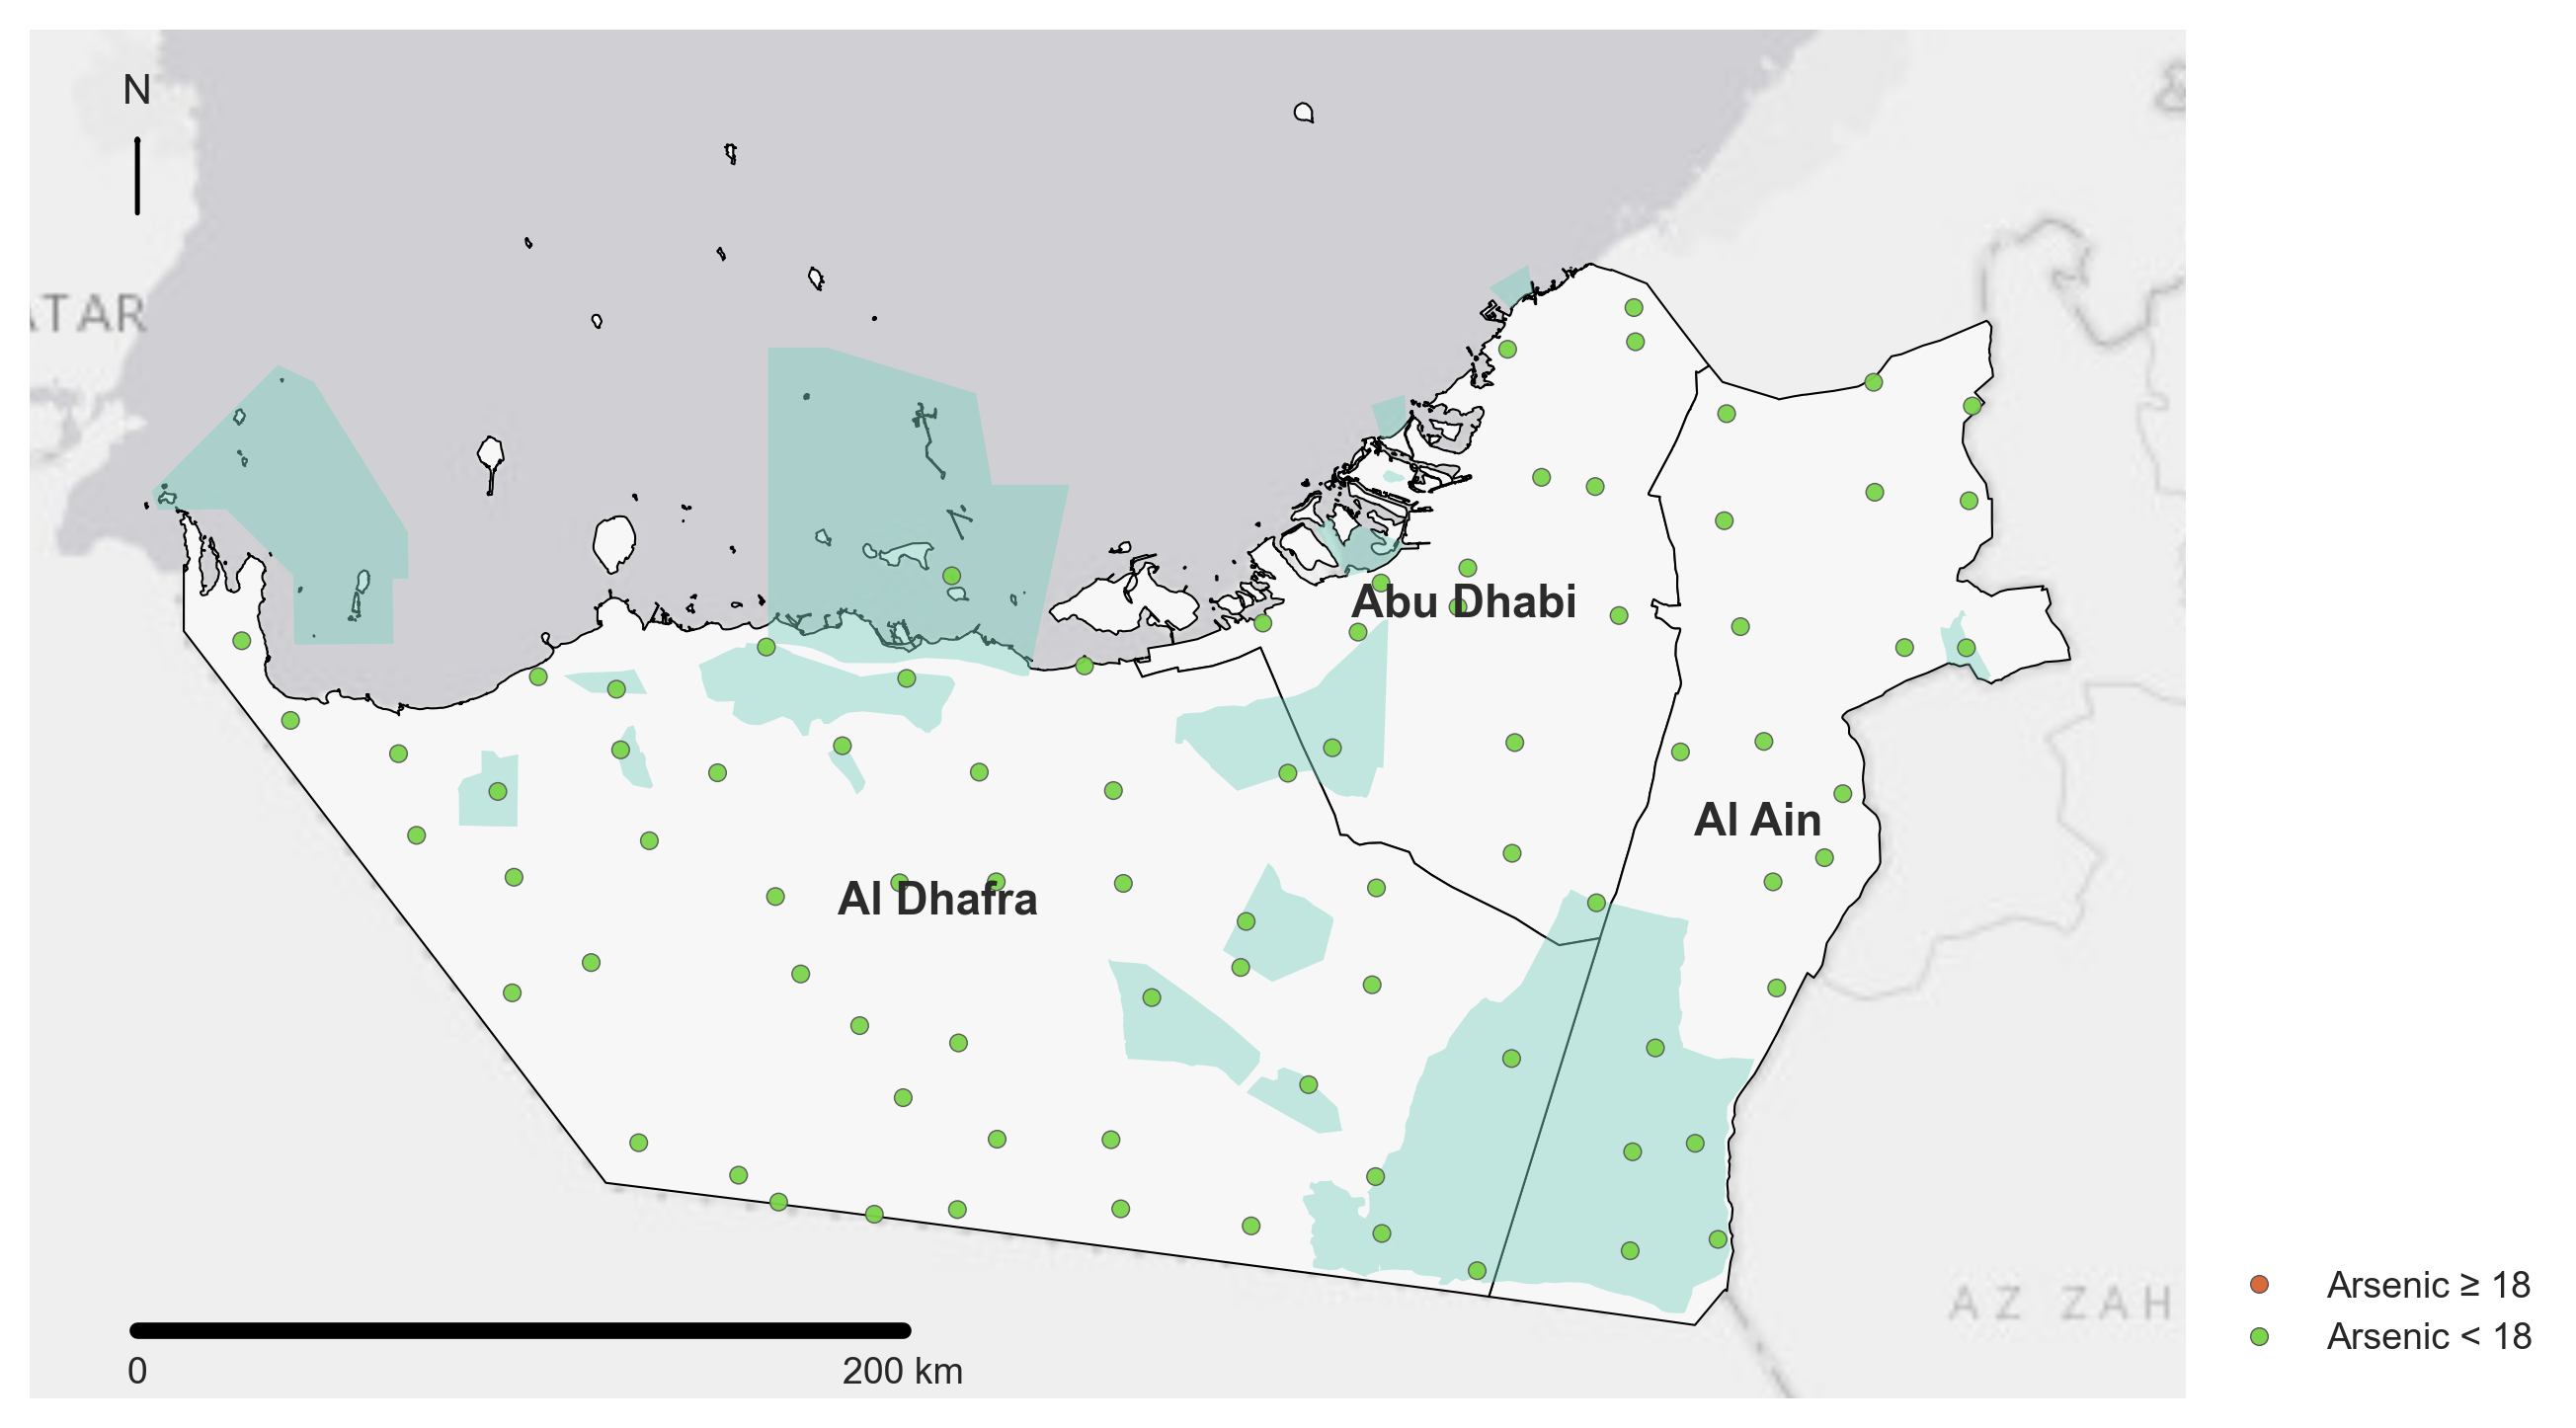

Sites (dedup by SiteUID): 84


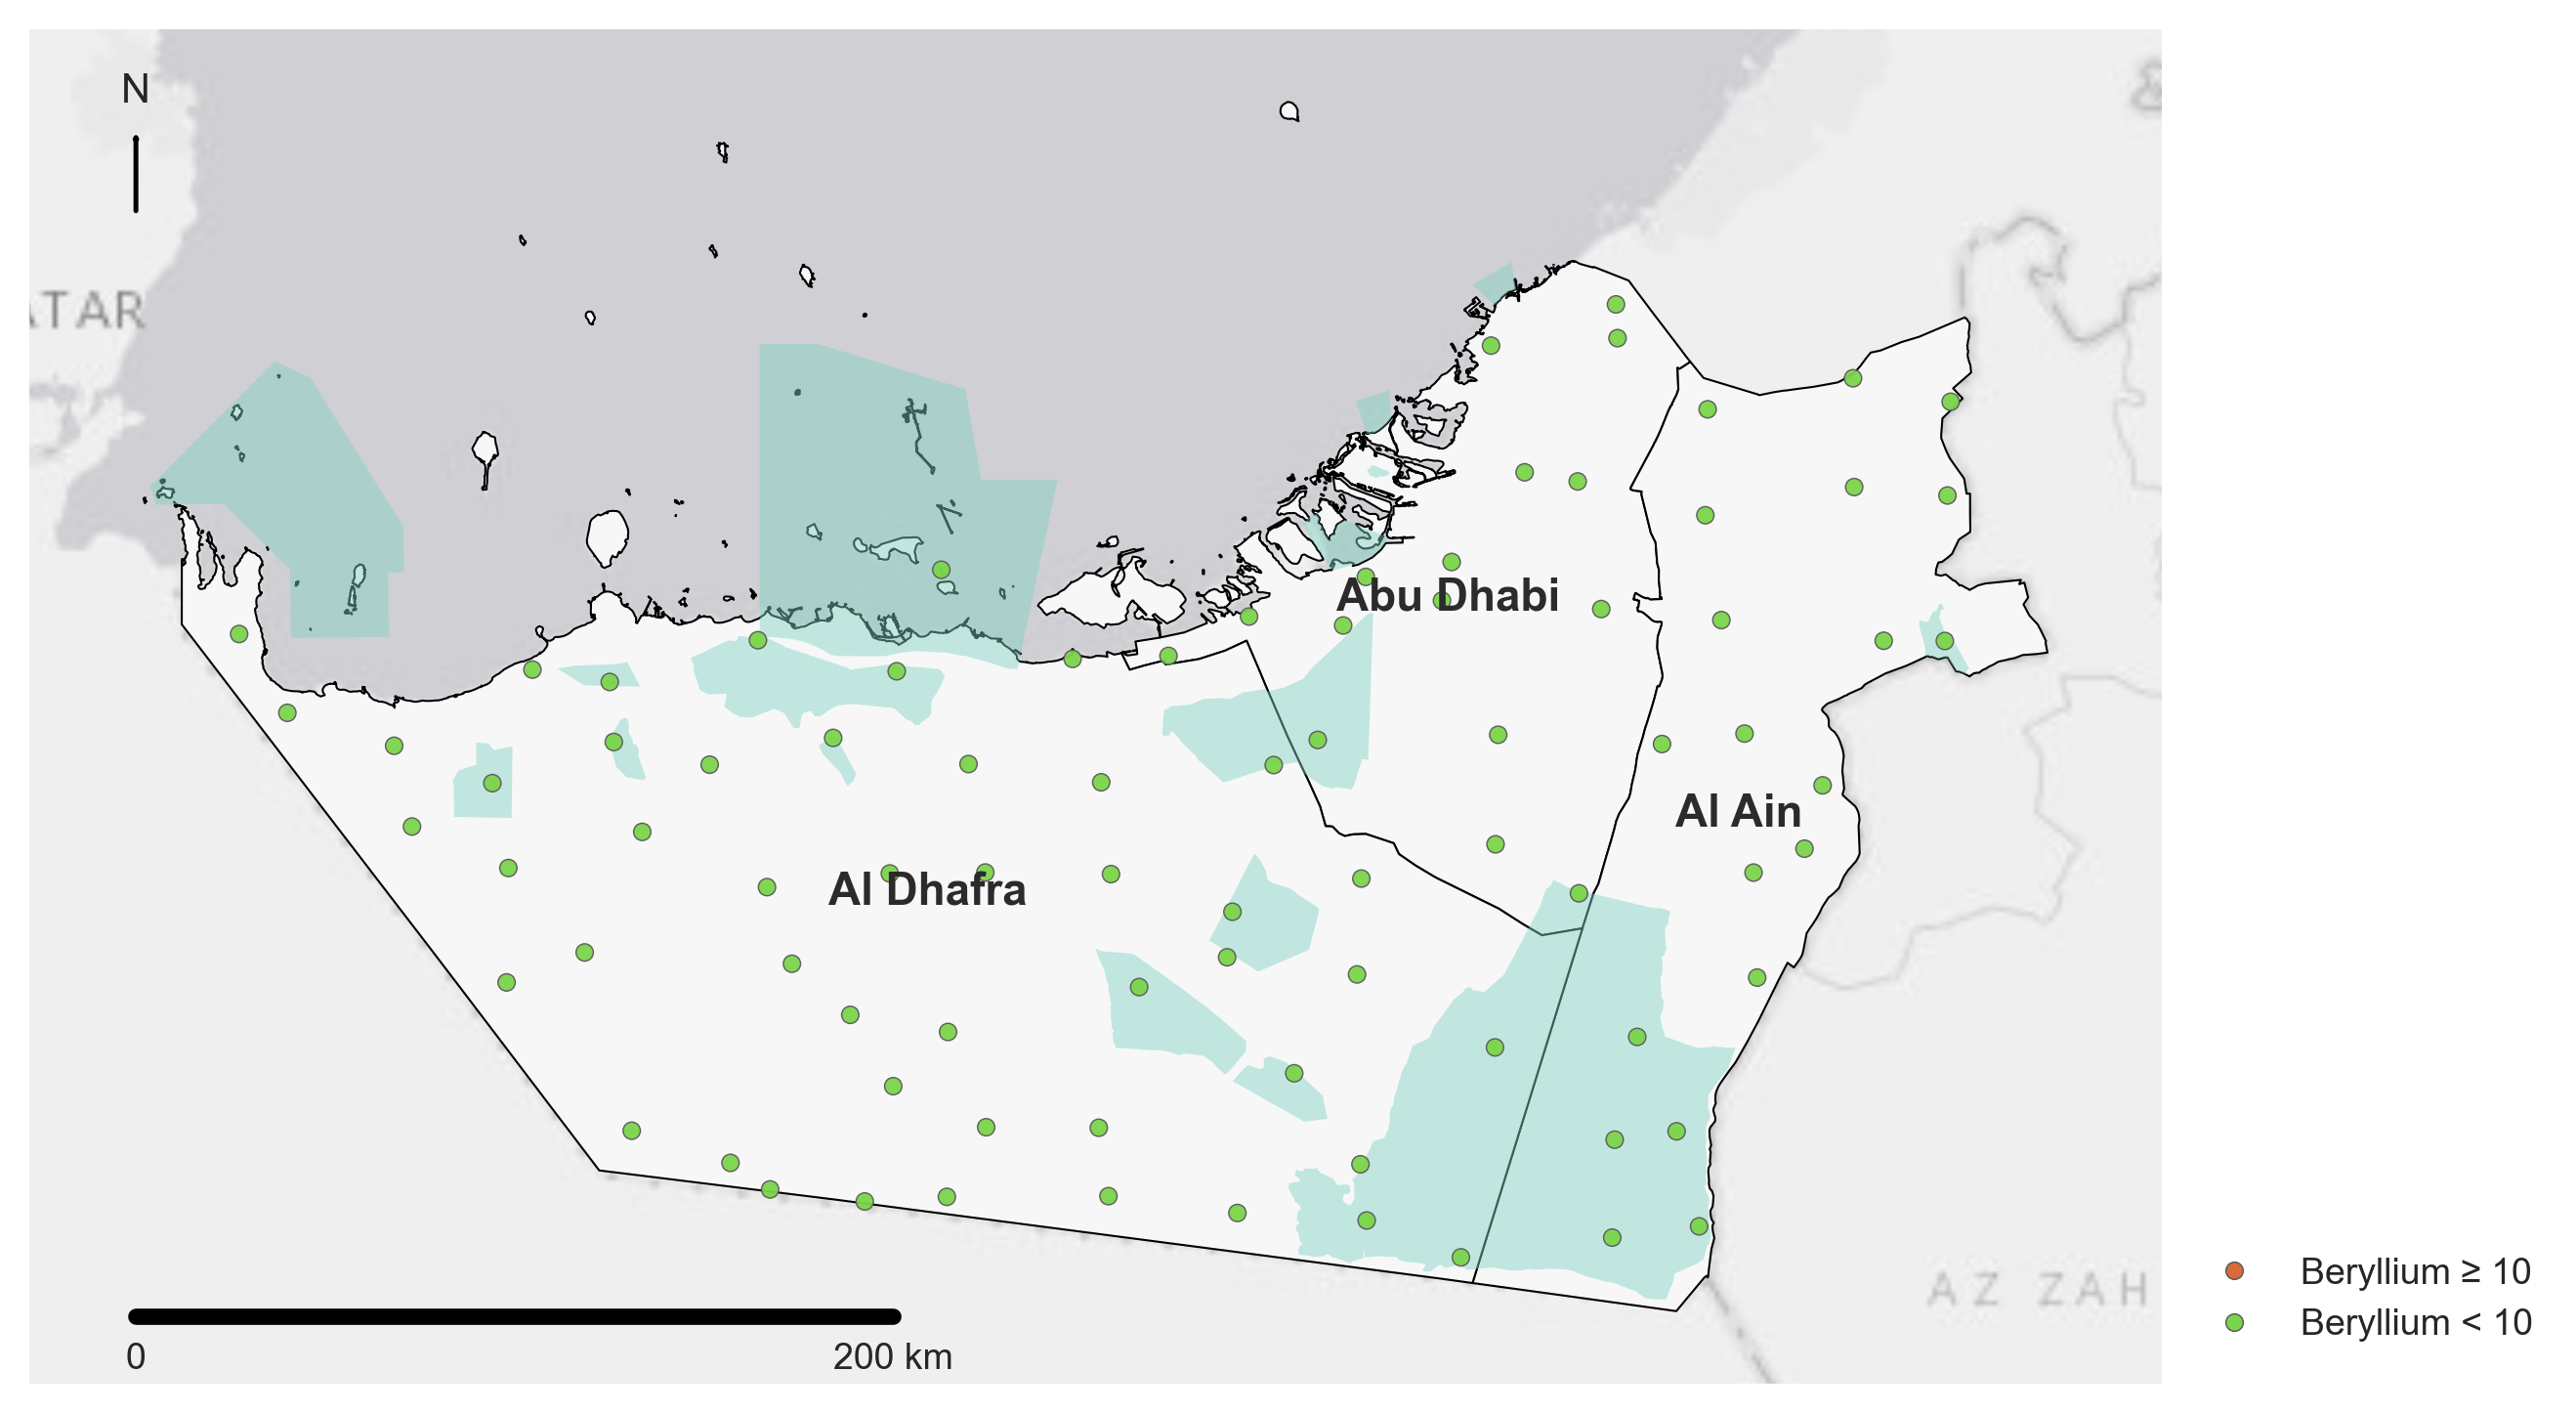

Sites (dedup by SiteUID): 83


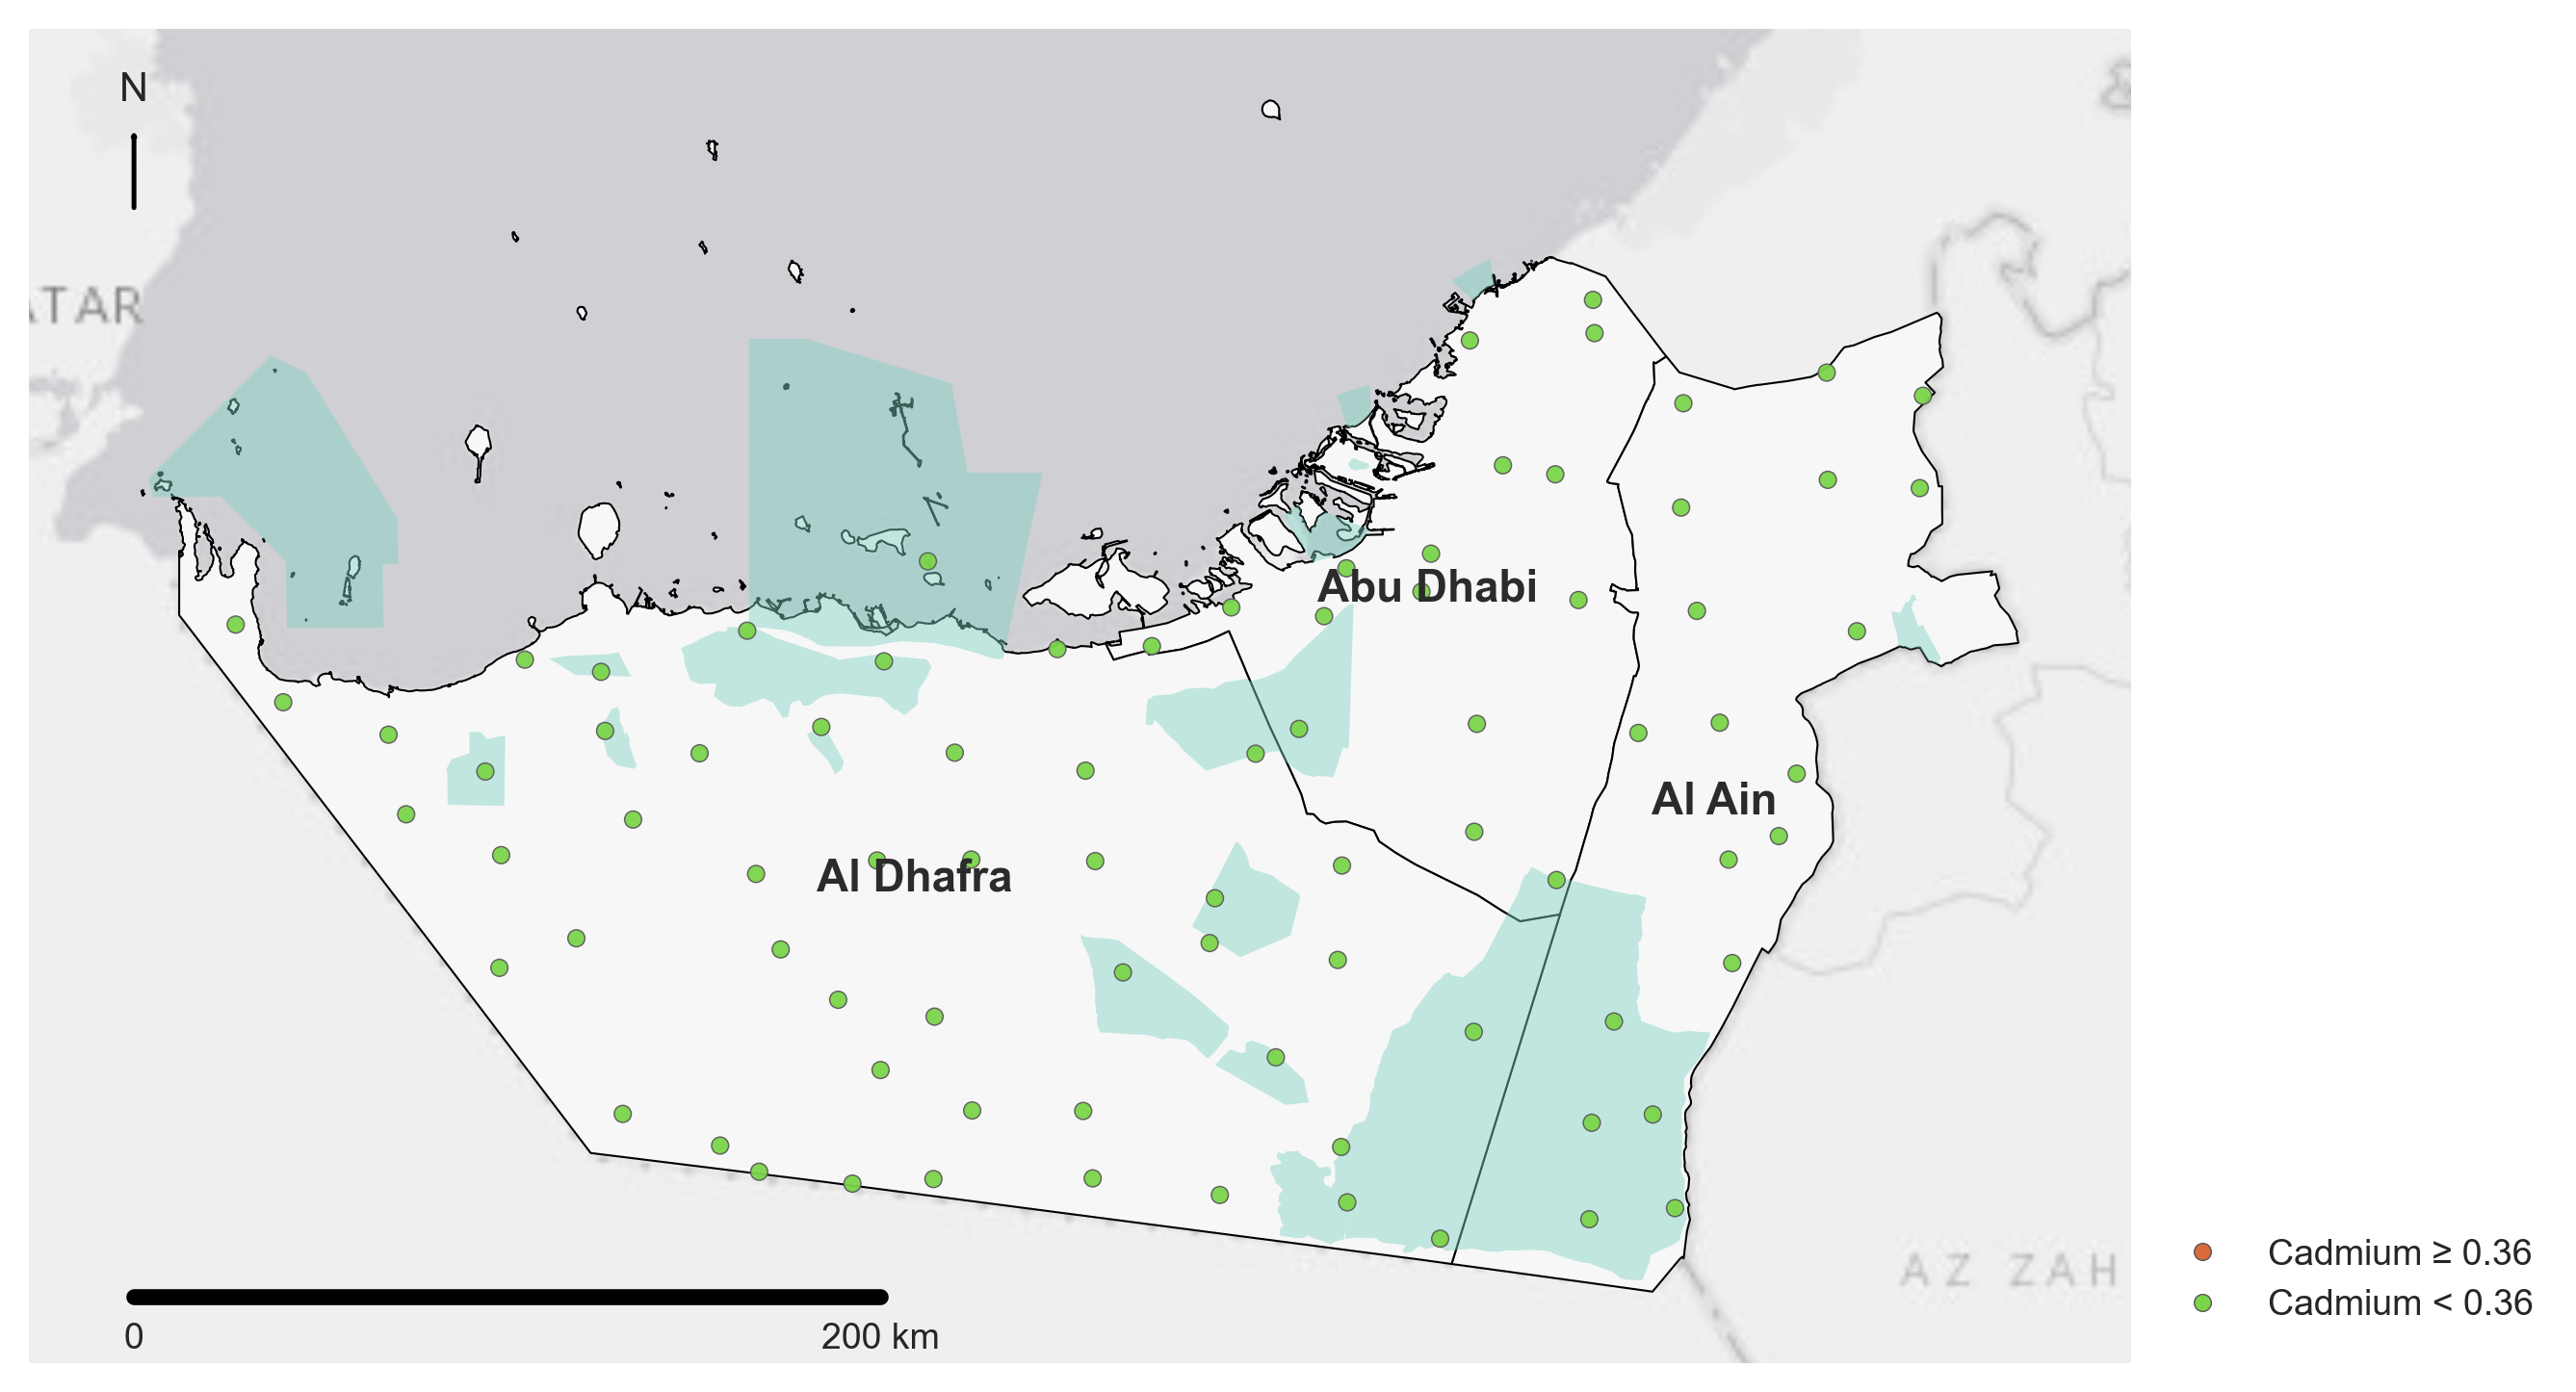

Sites (dedup by SiteUID): 84


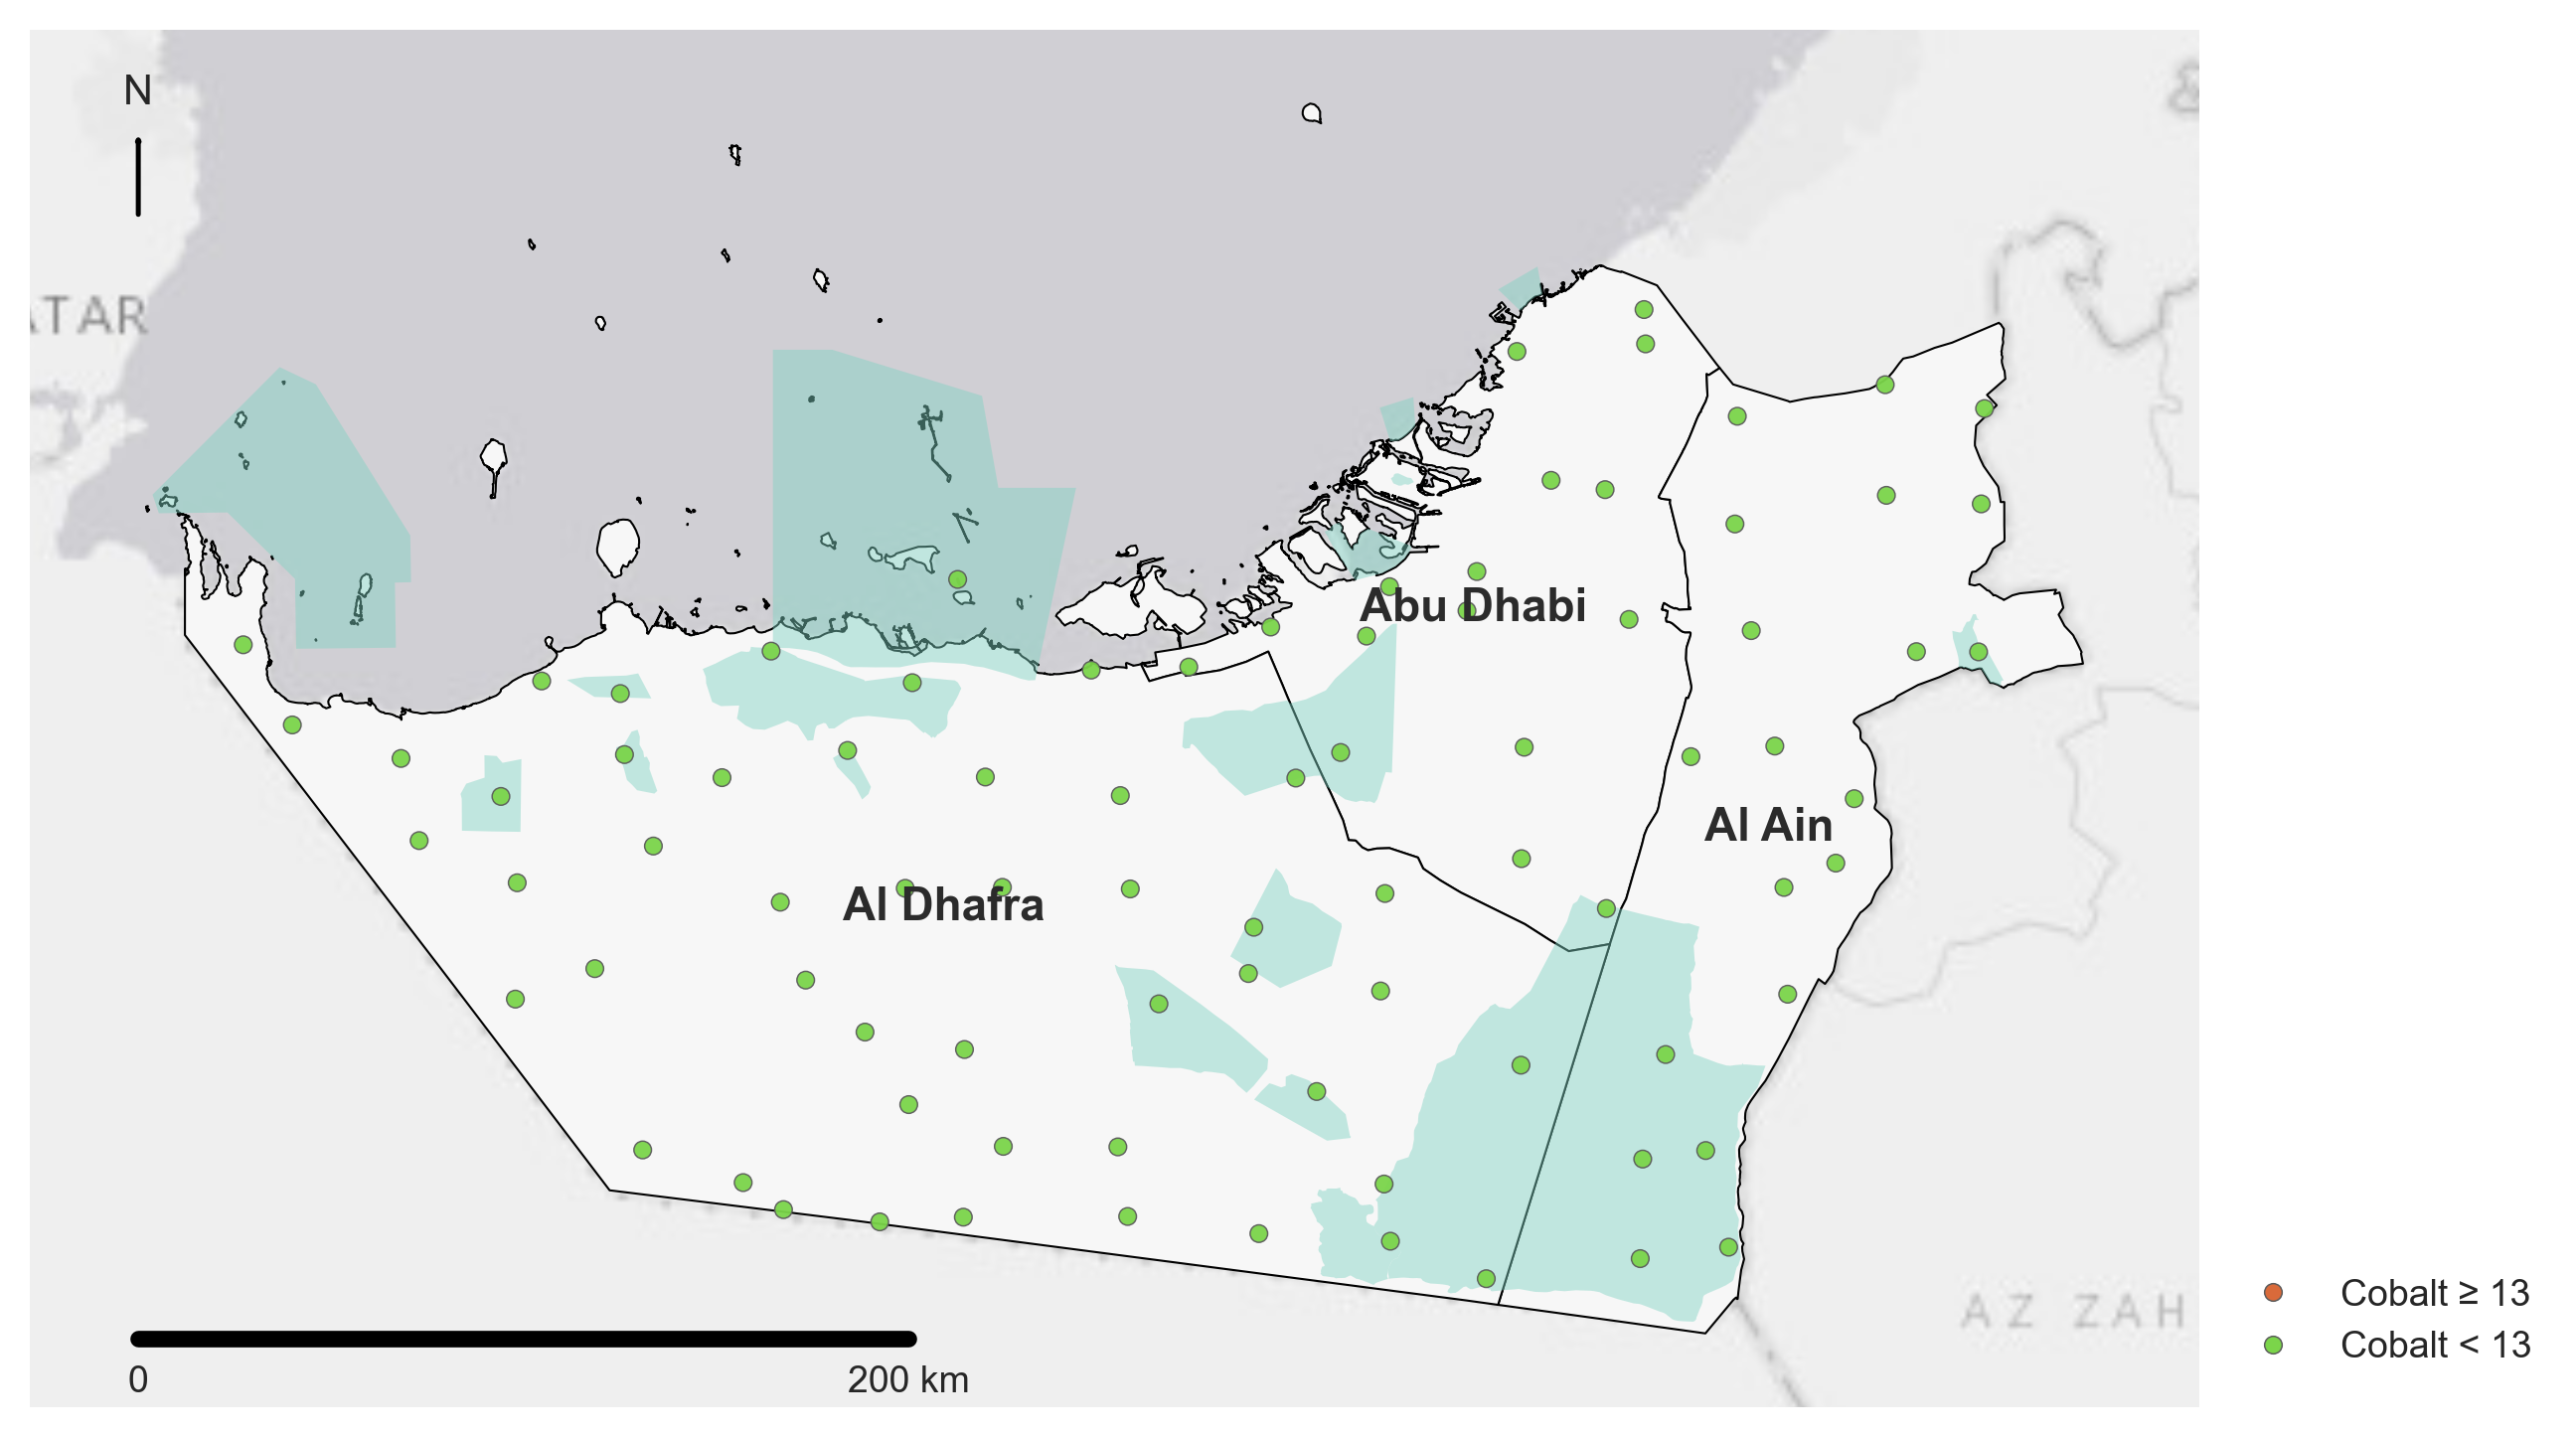

Sites (dedup by SiteUID): 84


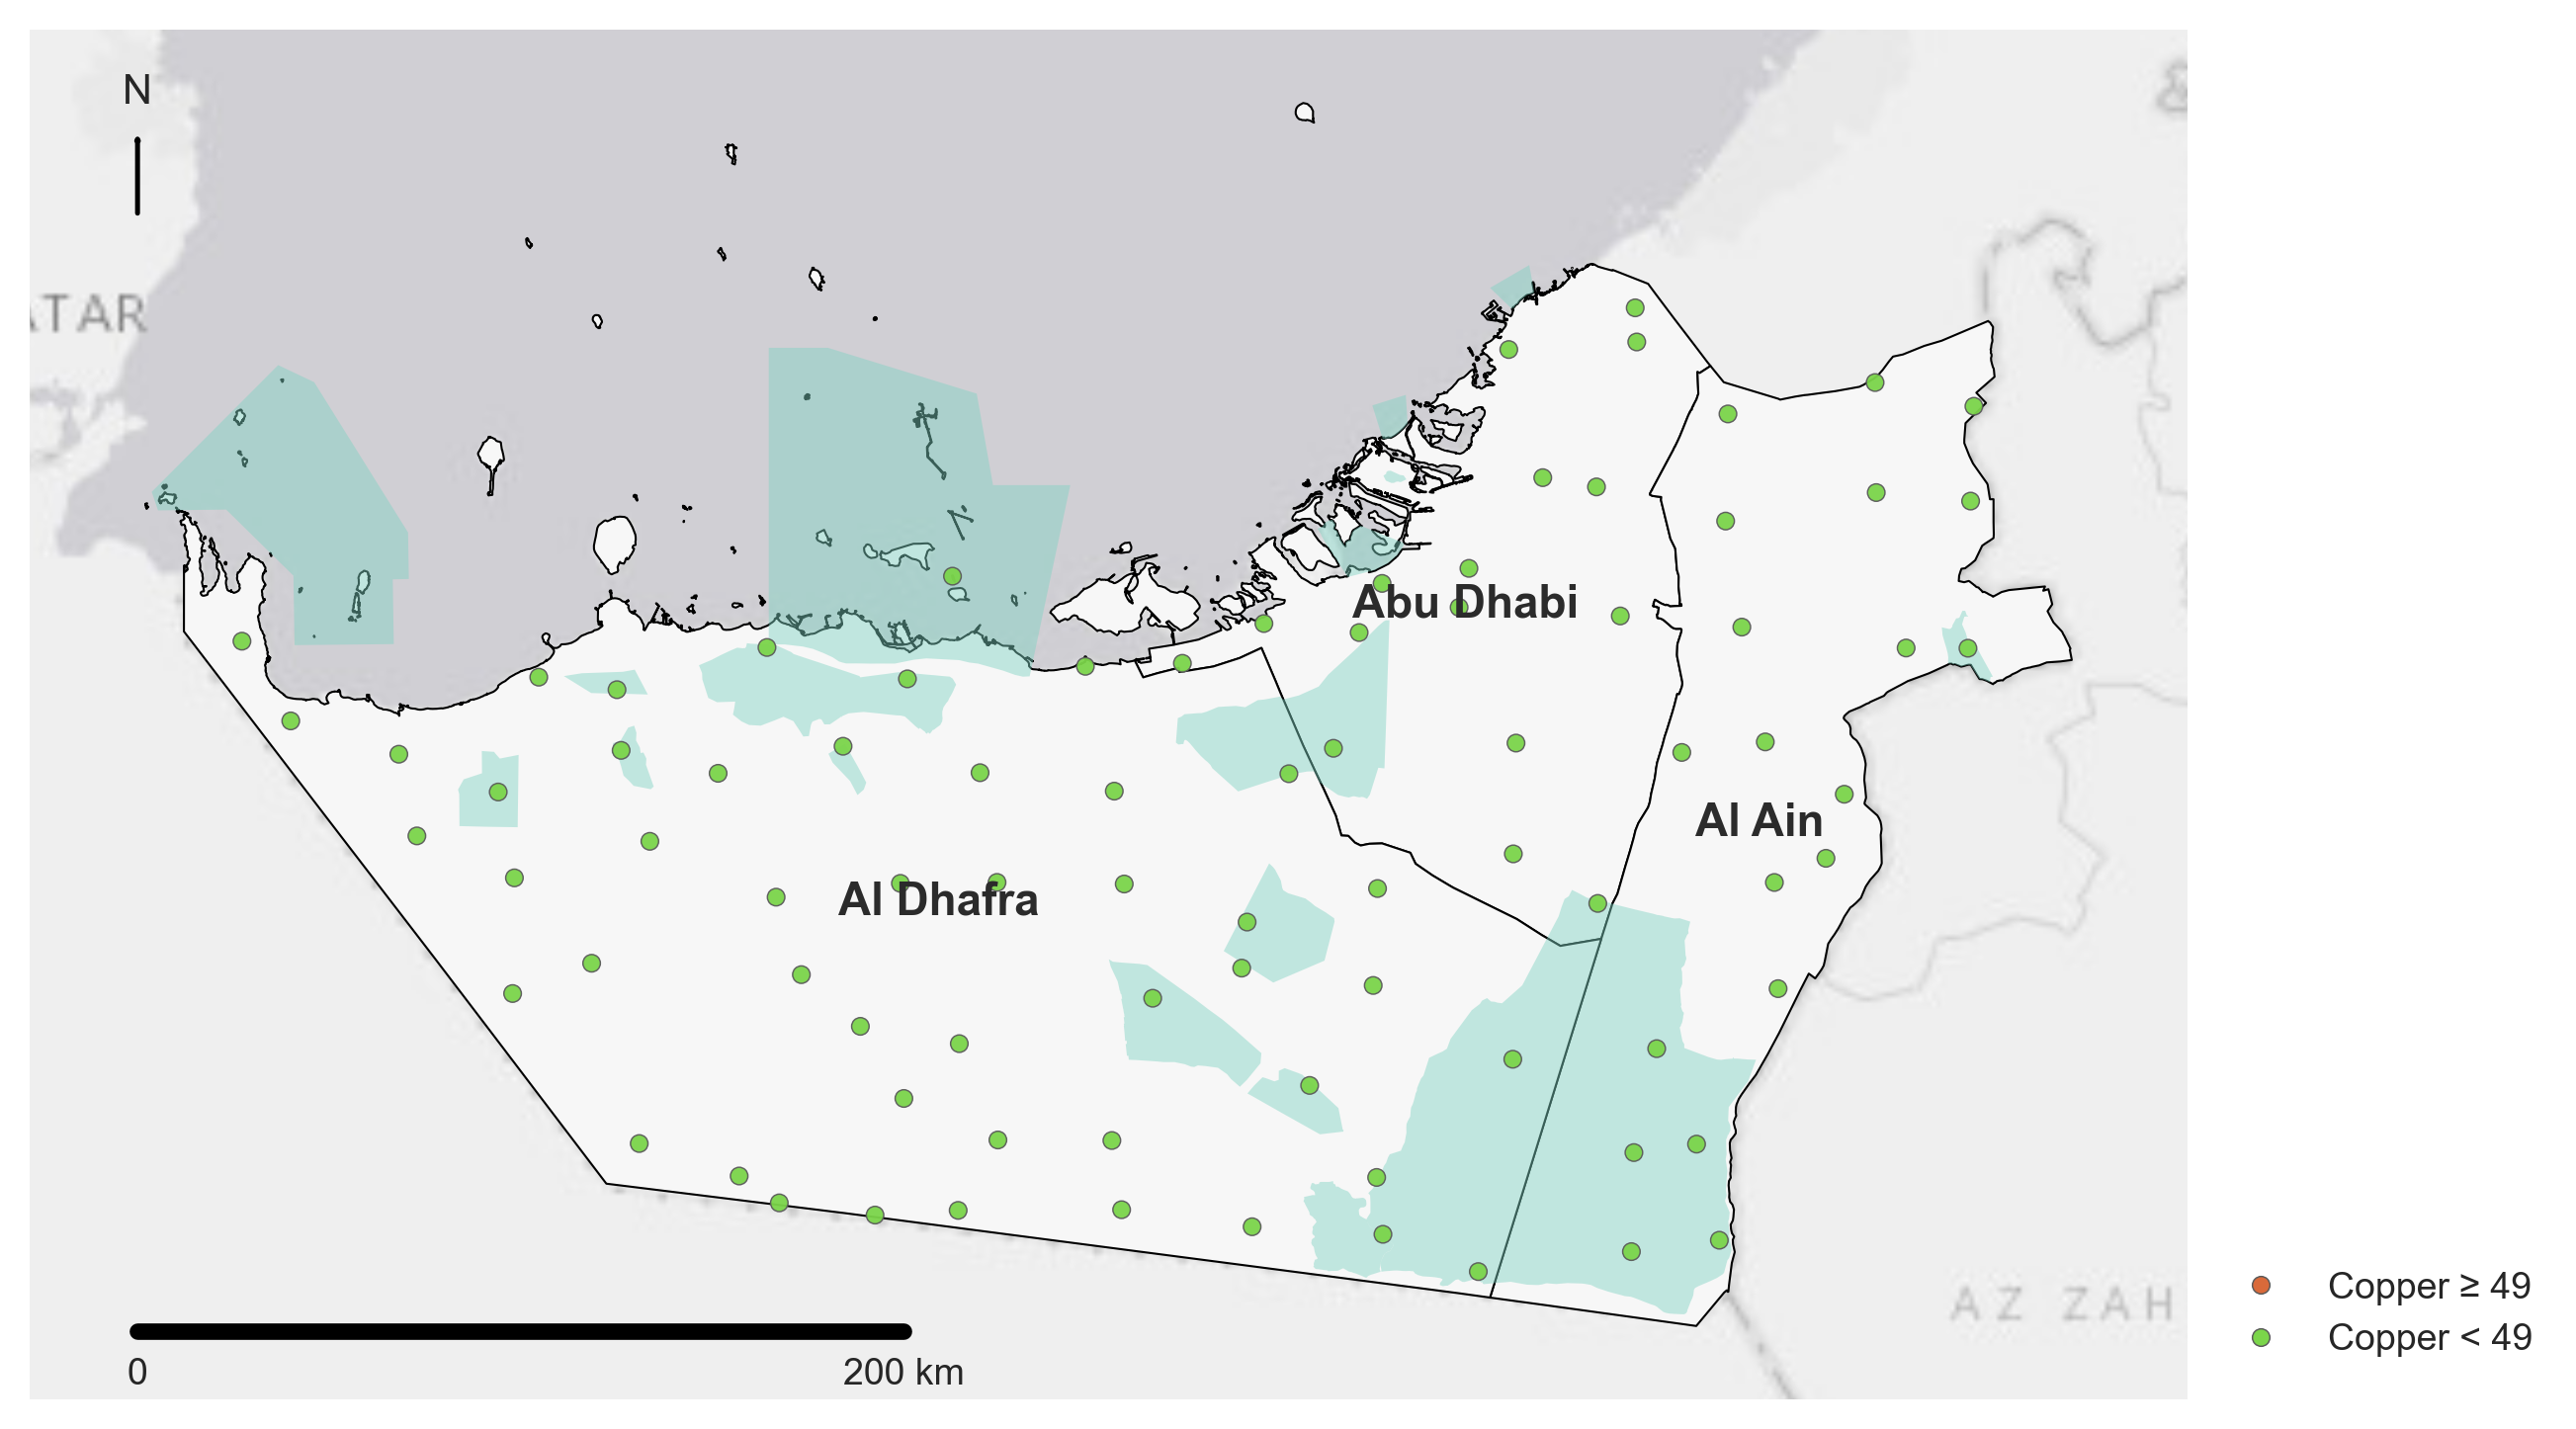

Sites (dedup by SiteUID): 84


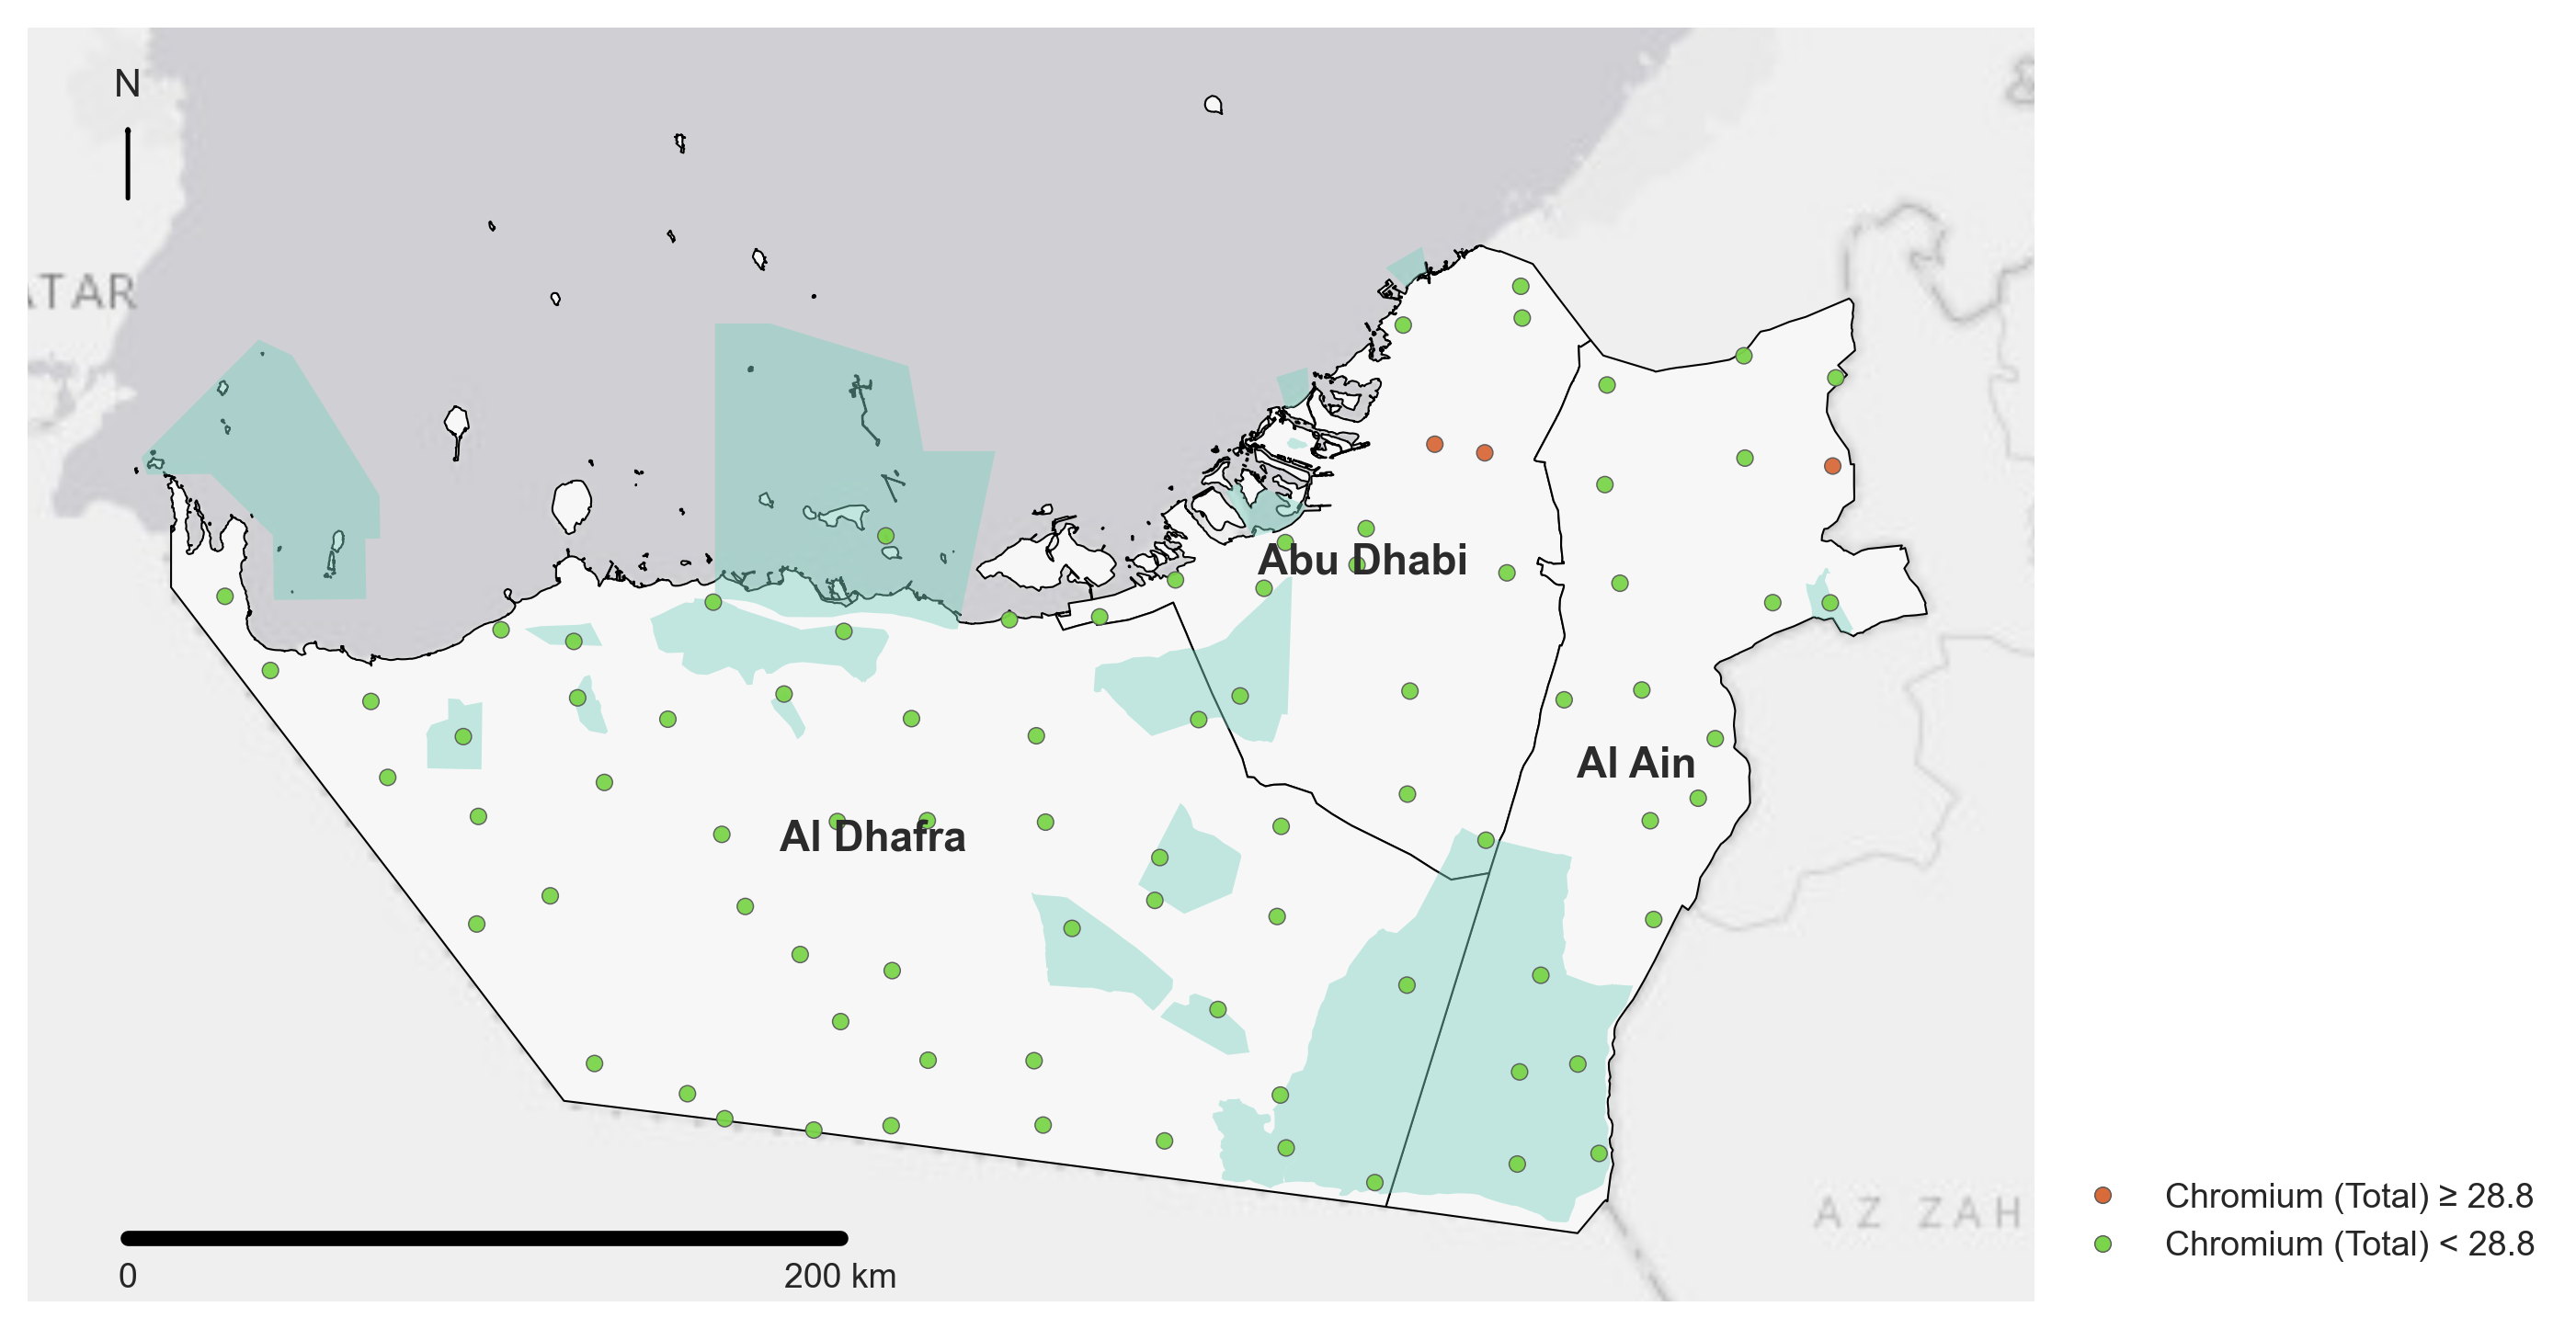

Sites (dedup by SiteUID): 84


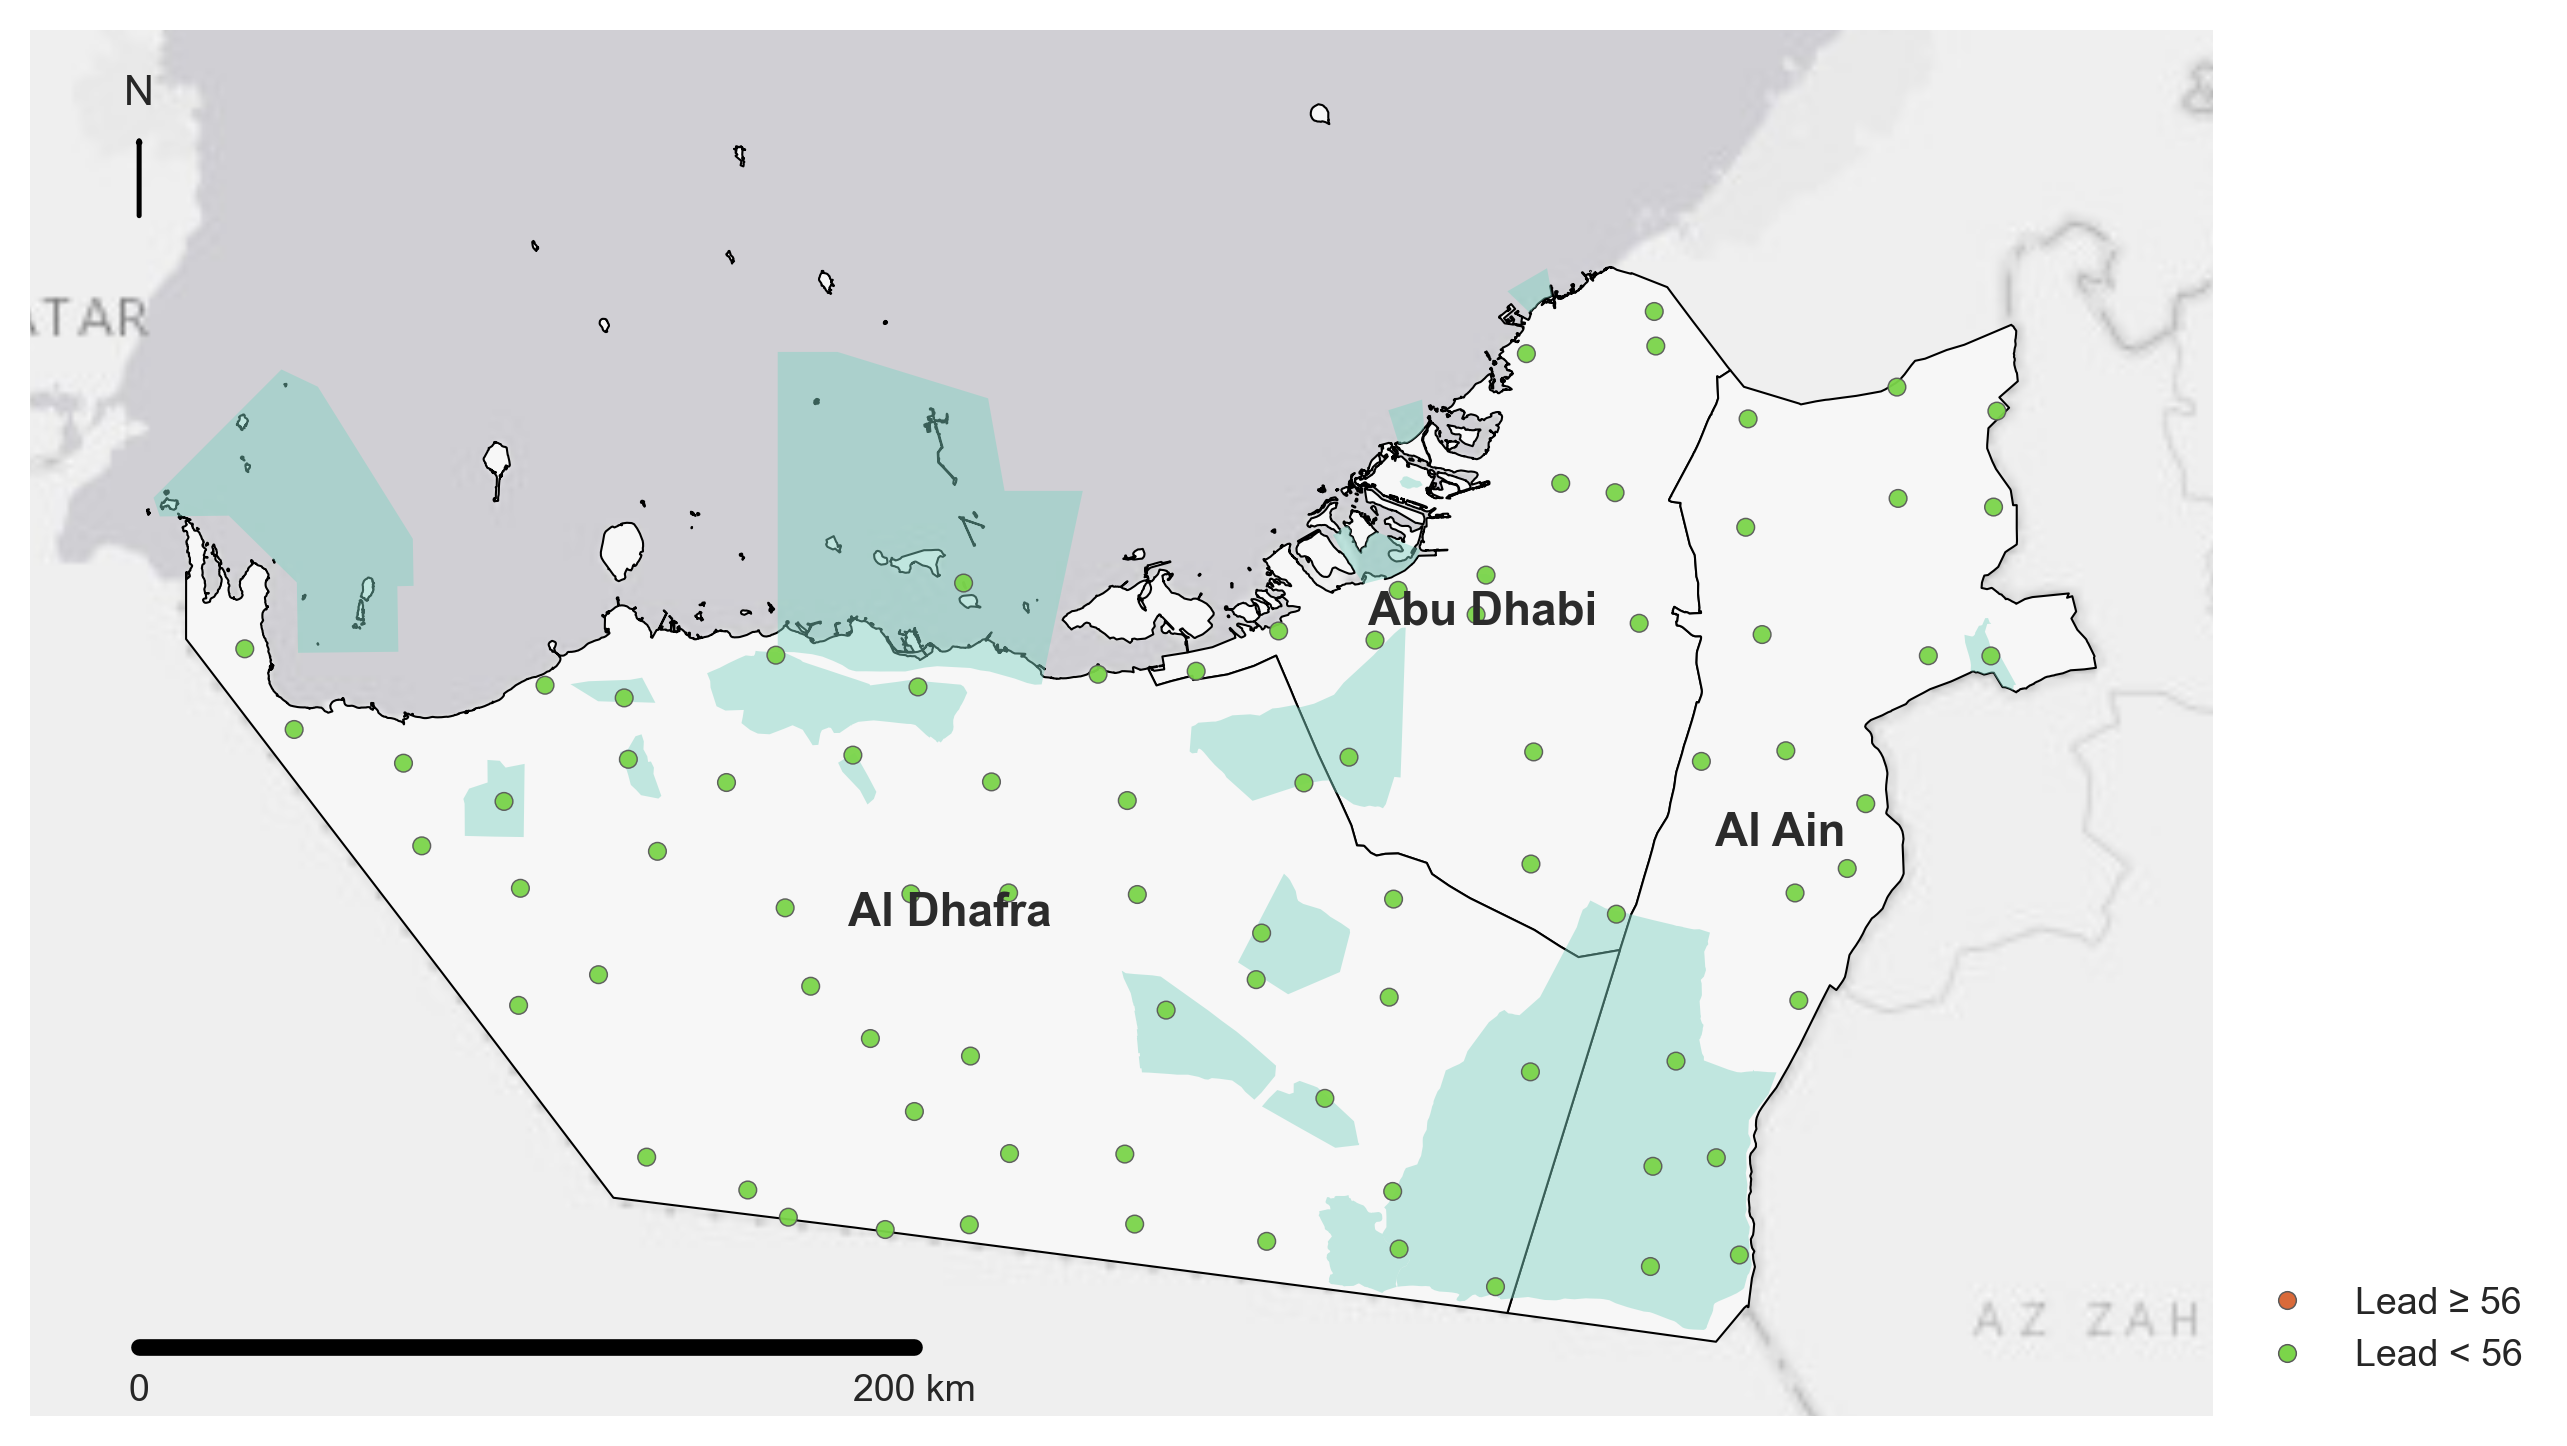

Sites (dedup by SiteUID): 84


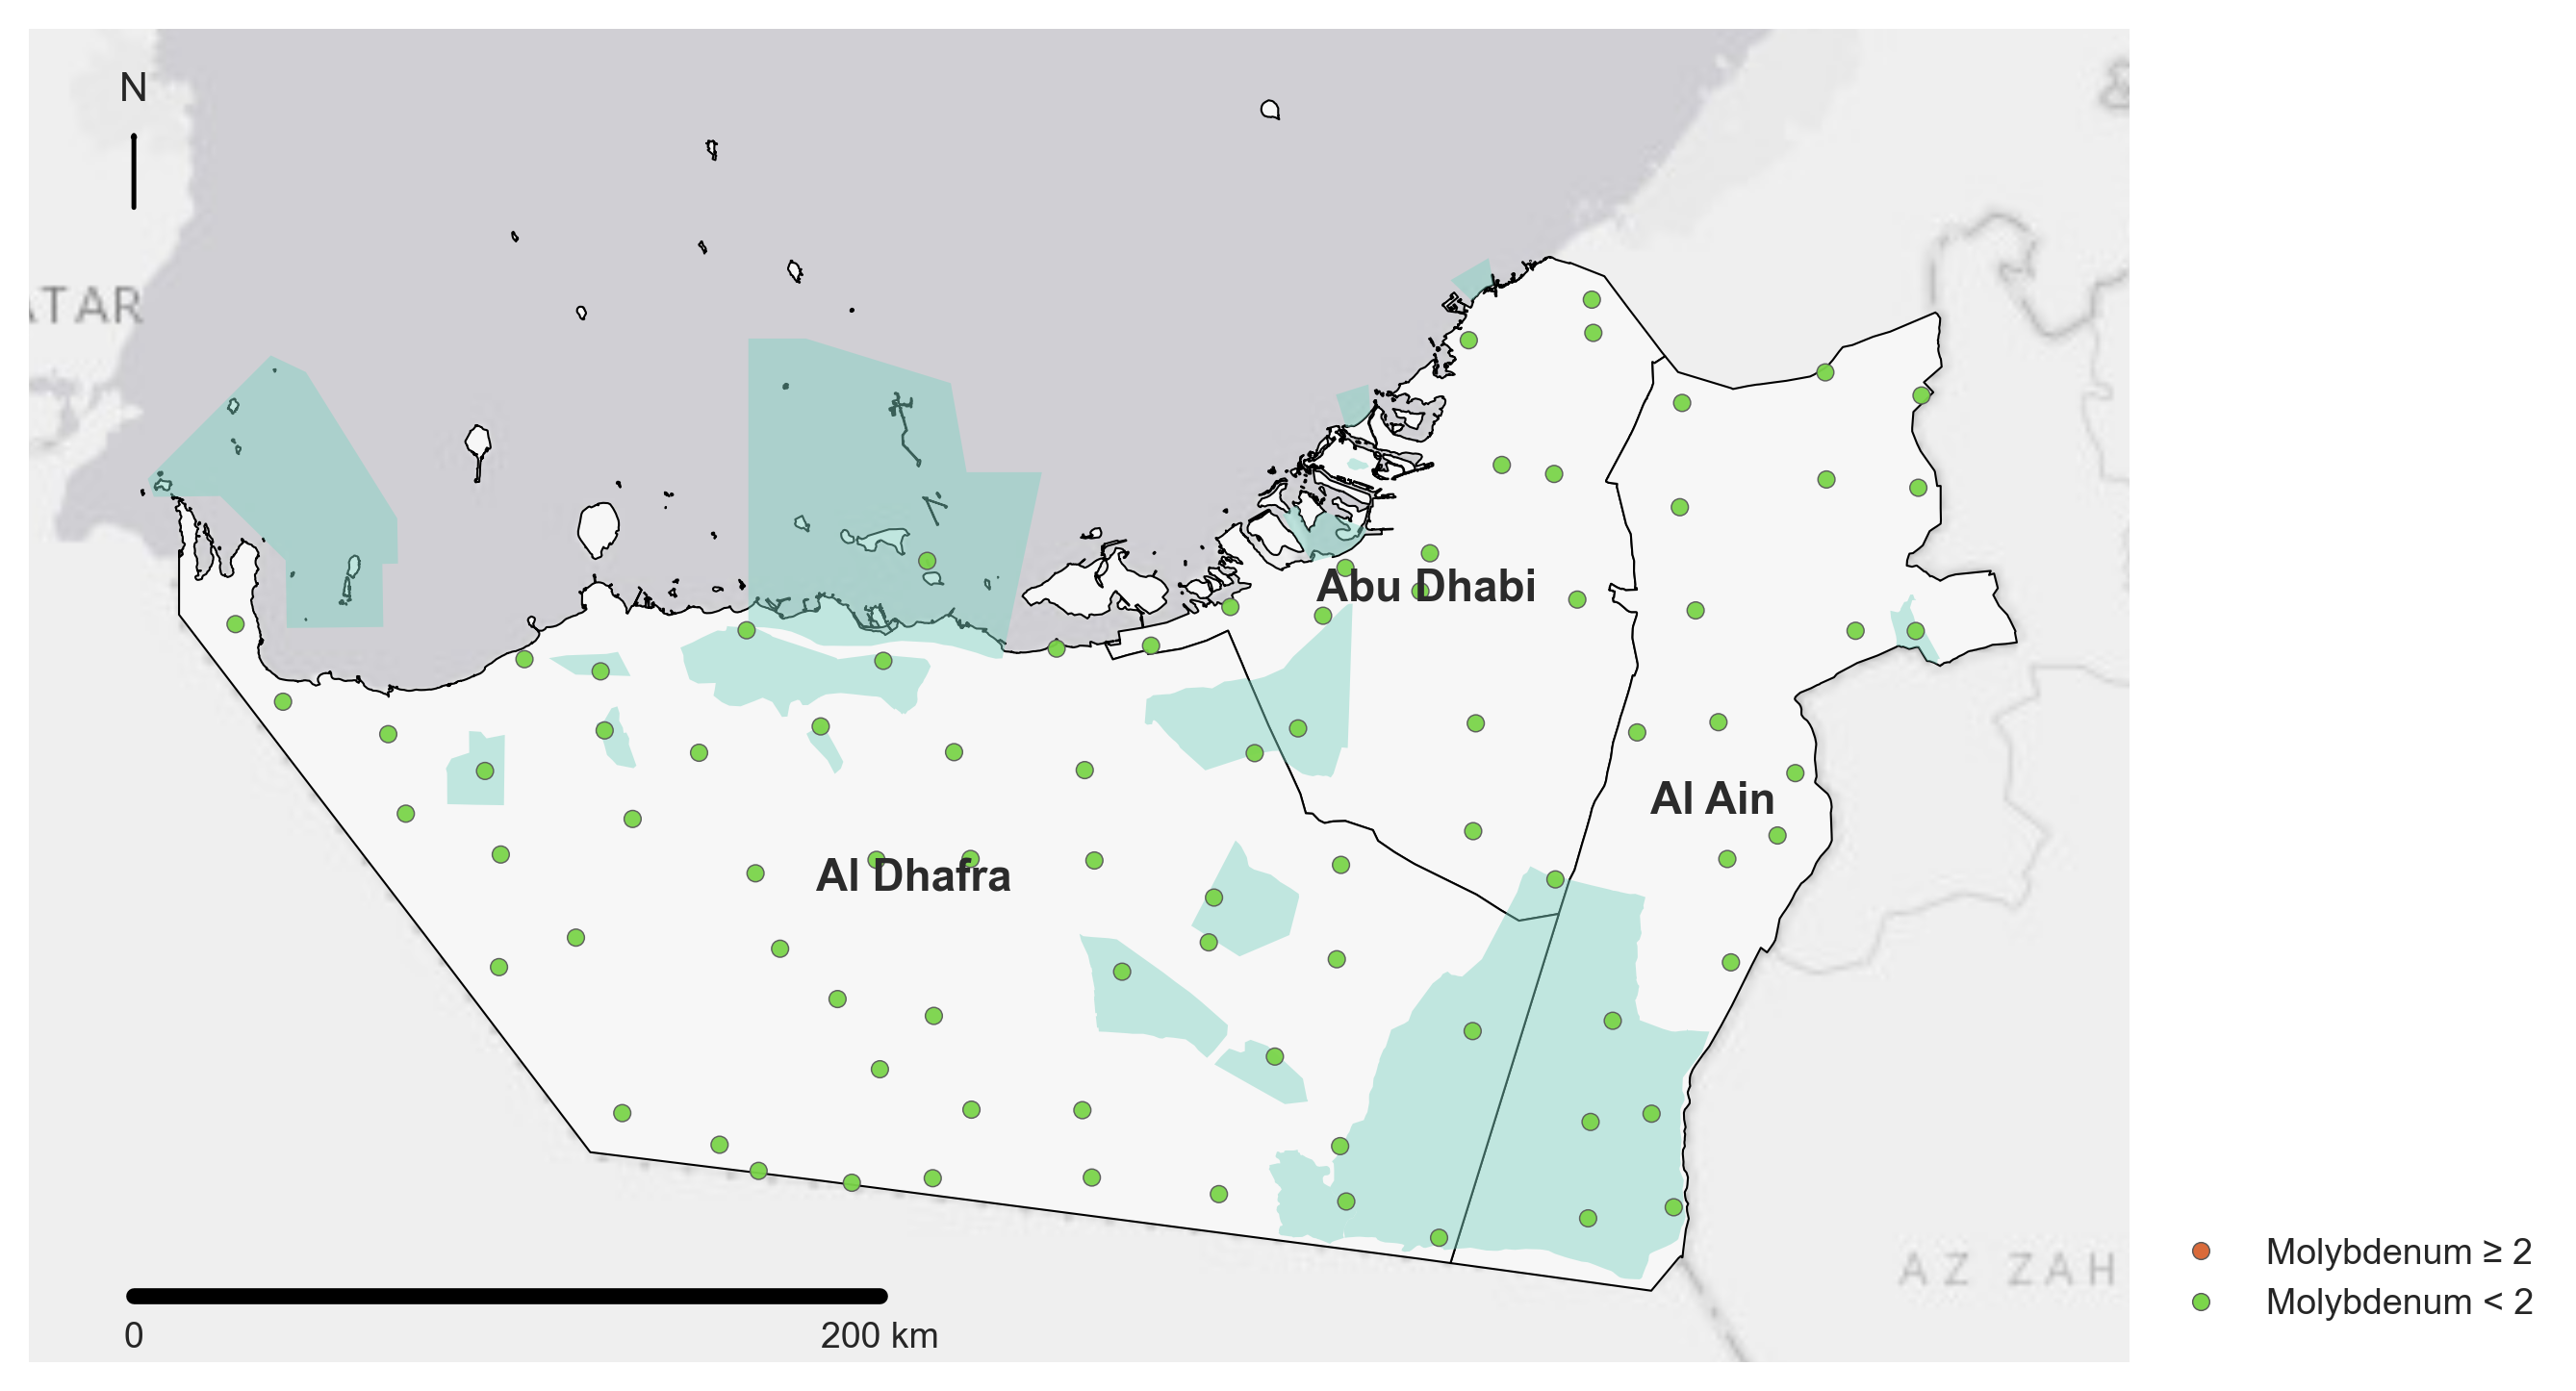

Sites (dedup by SiteUID): 84


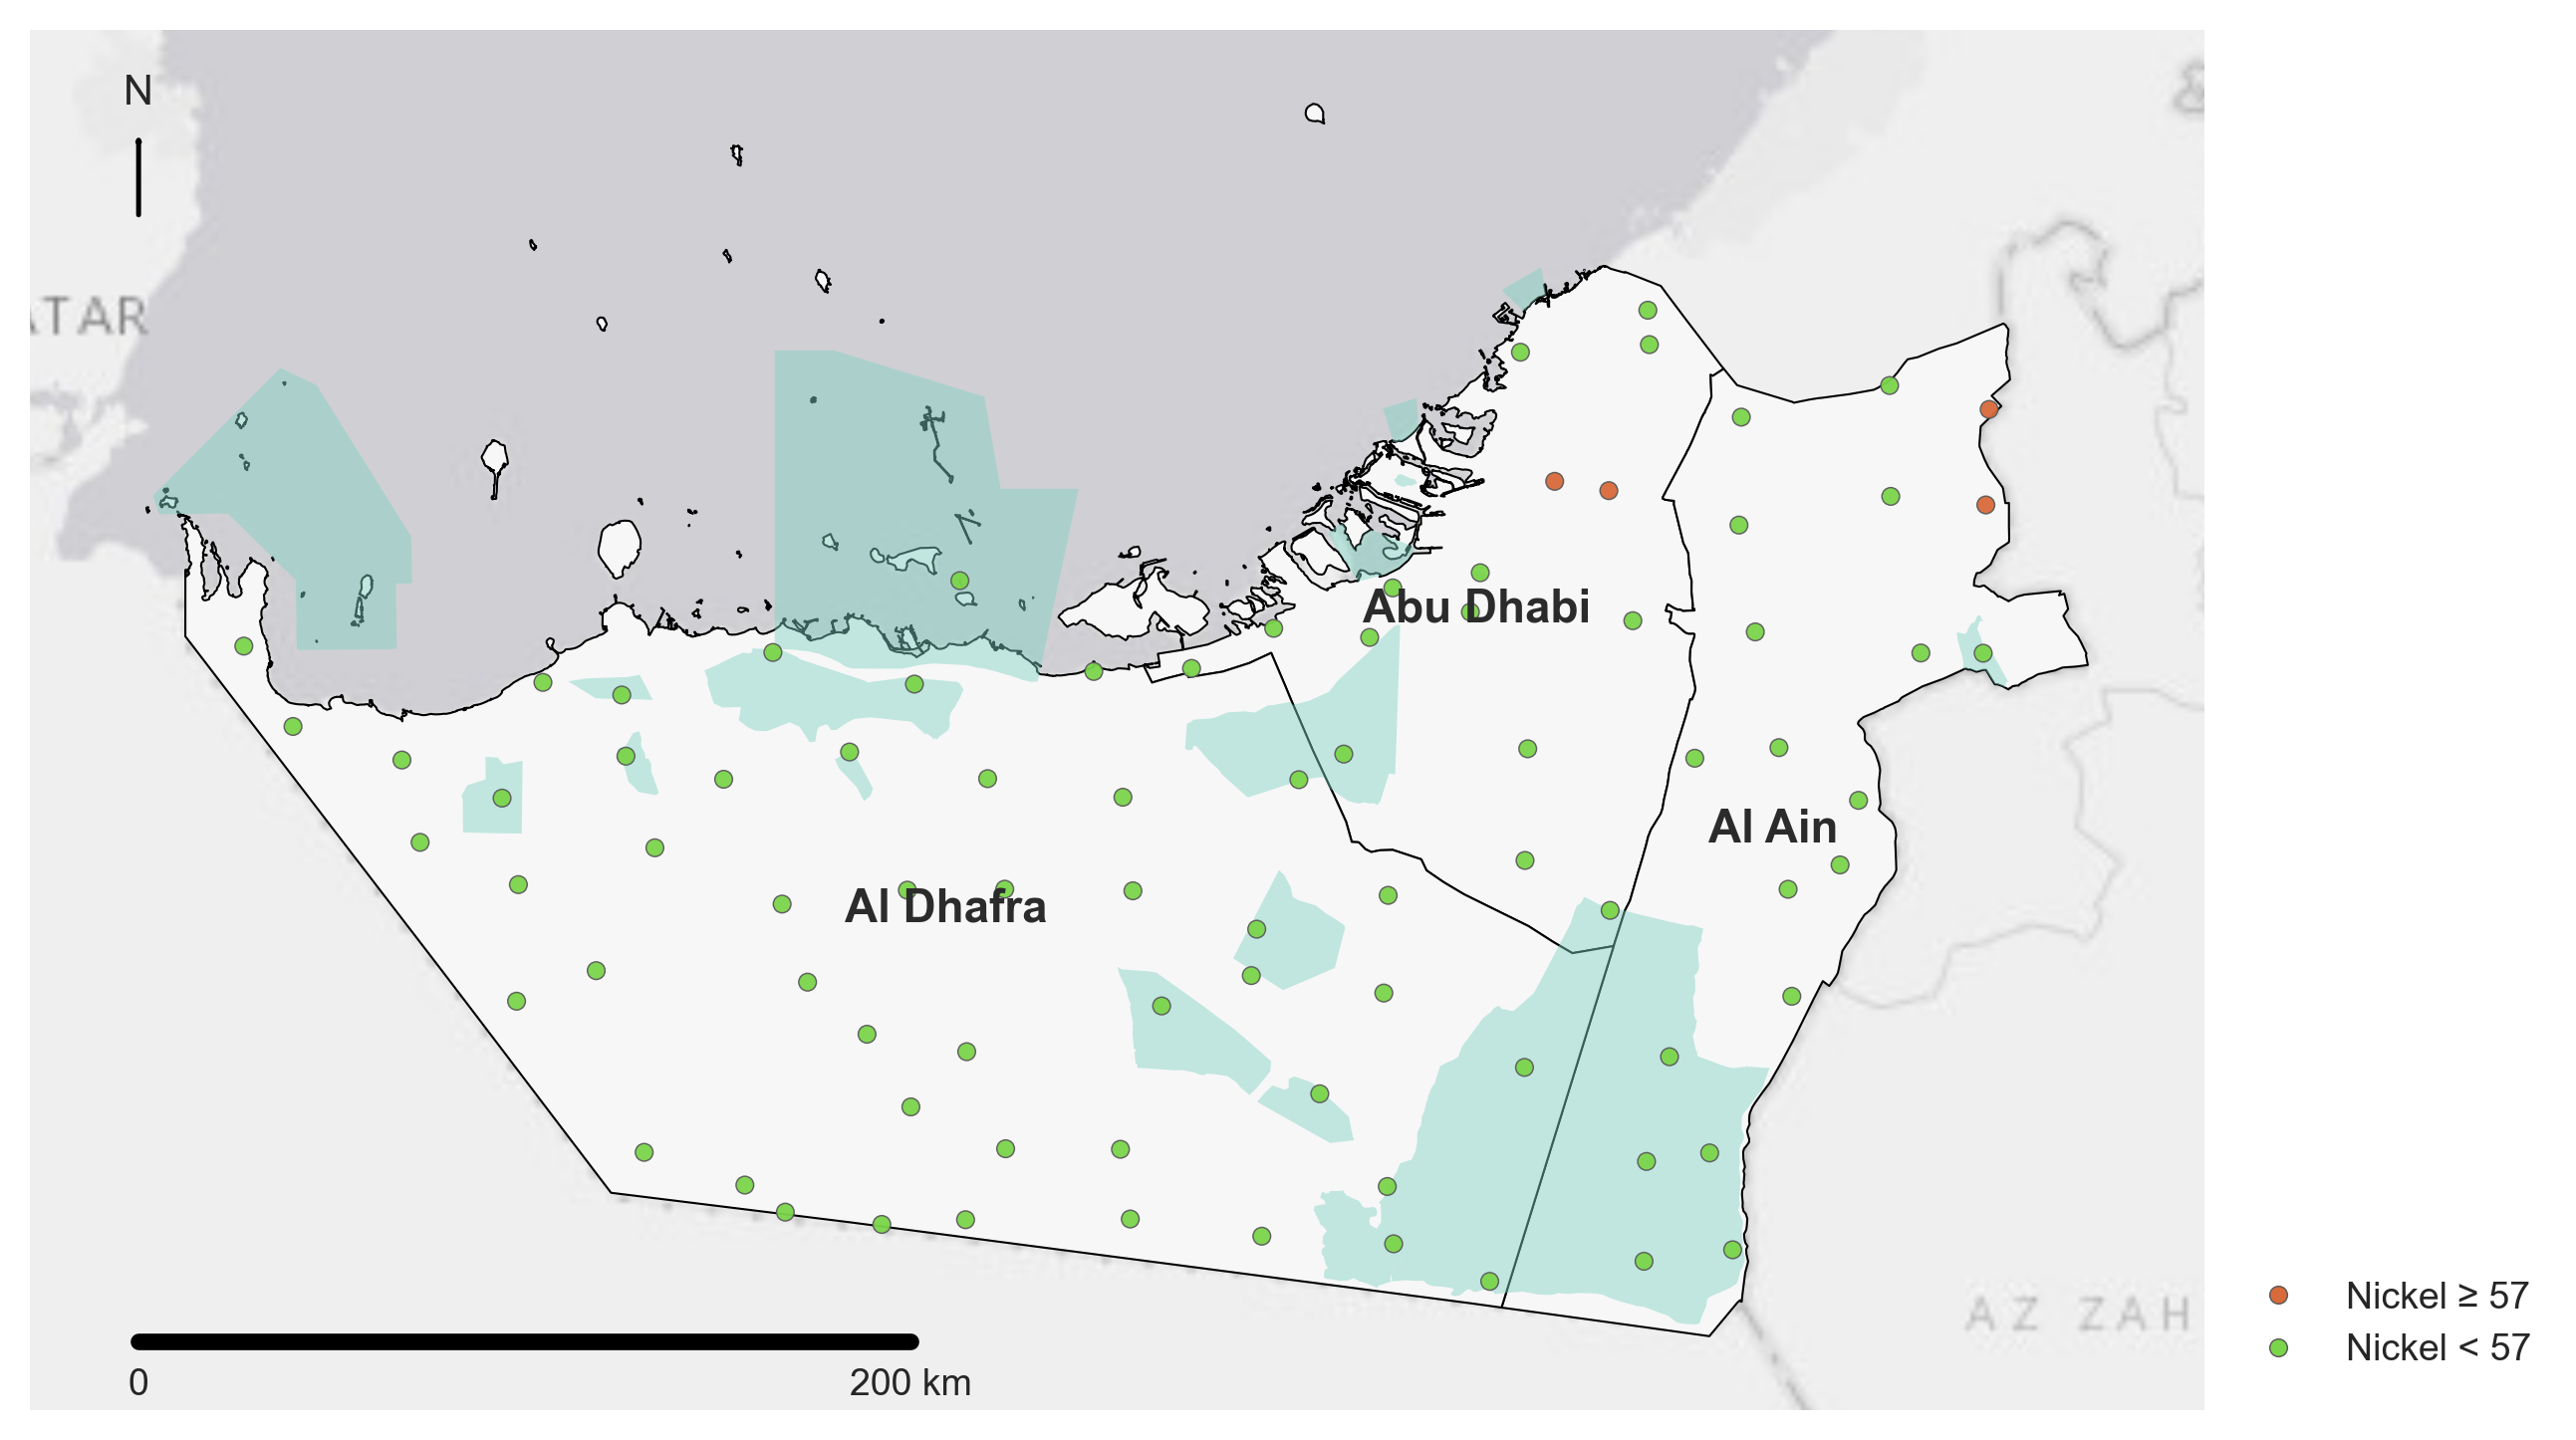

Sites (dedup by SiteUID): 84


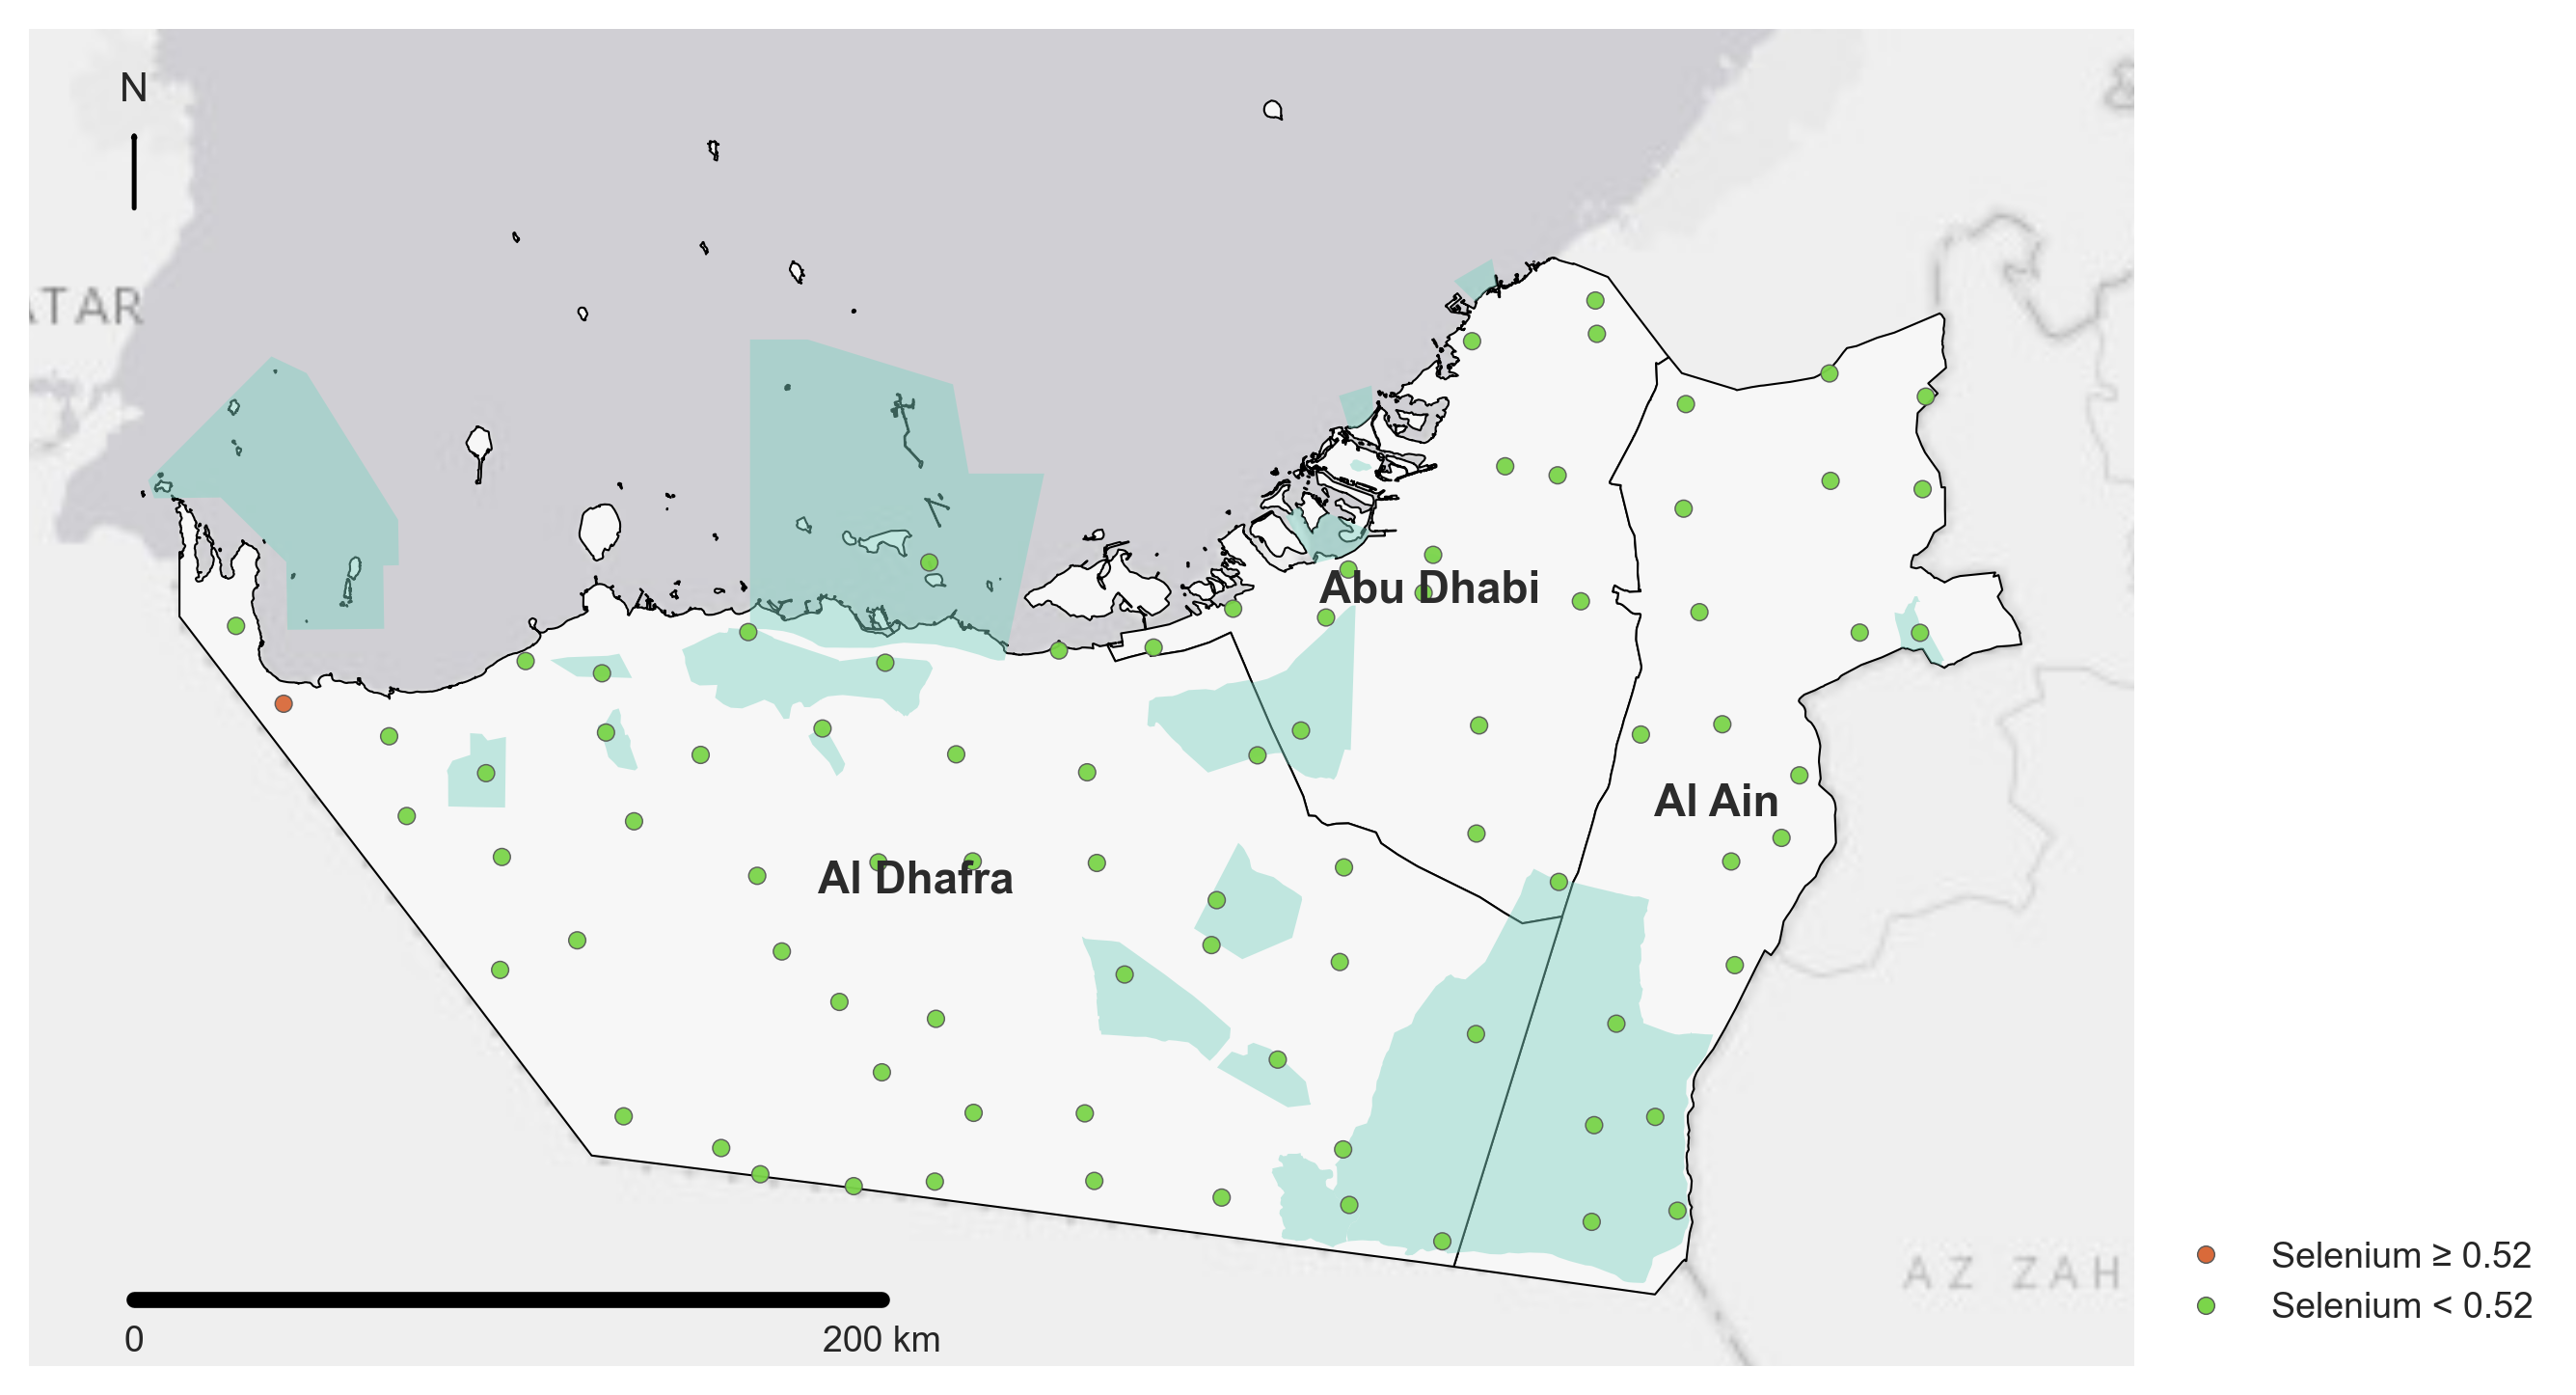

Sites (dedup by SiteUID): 84


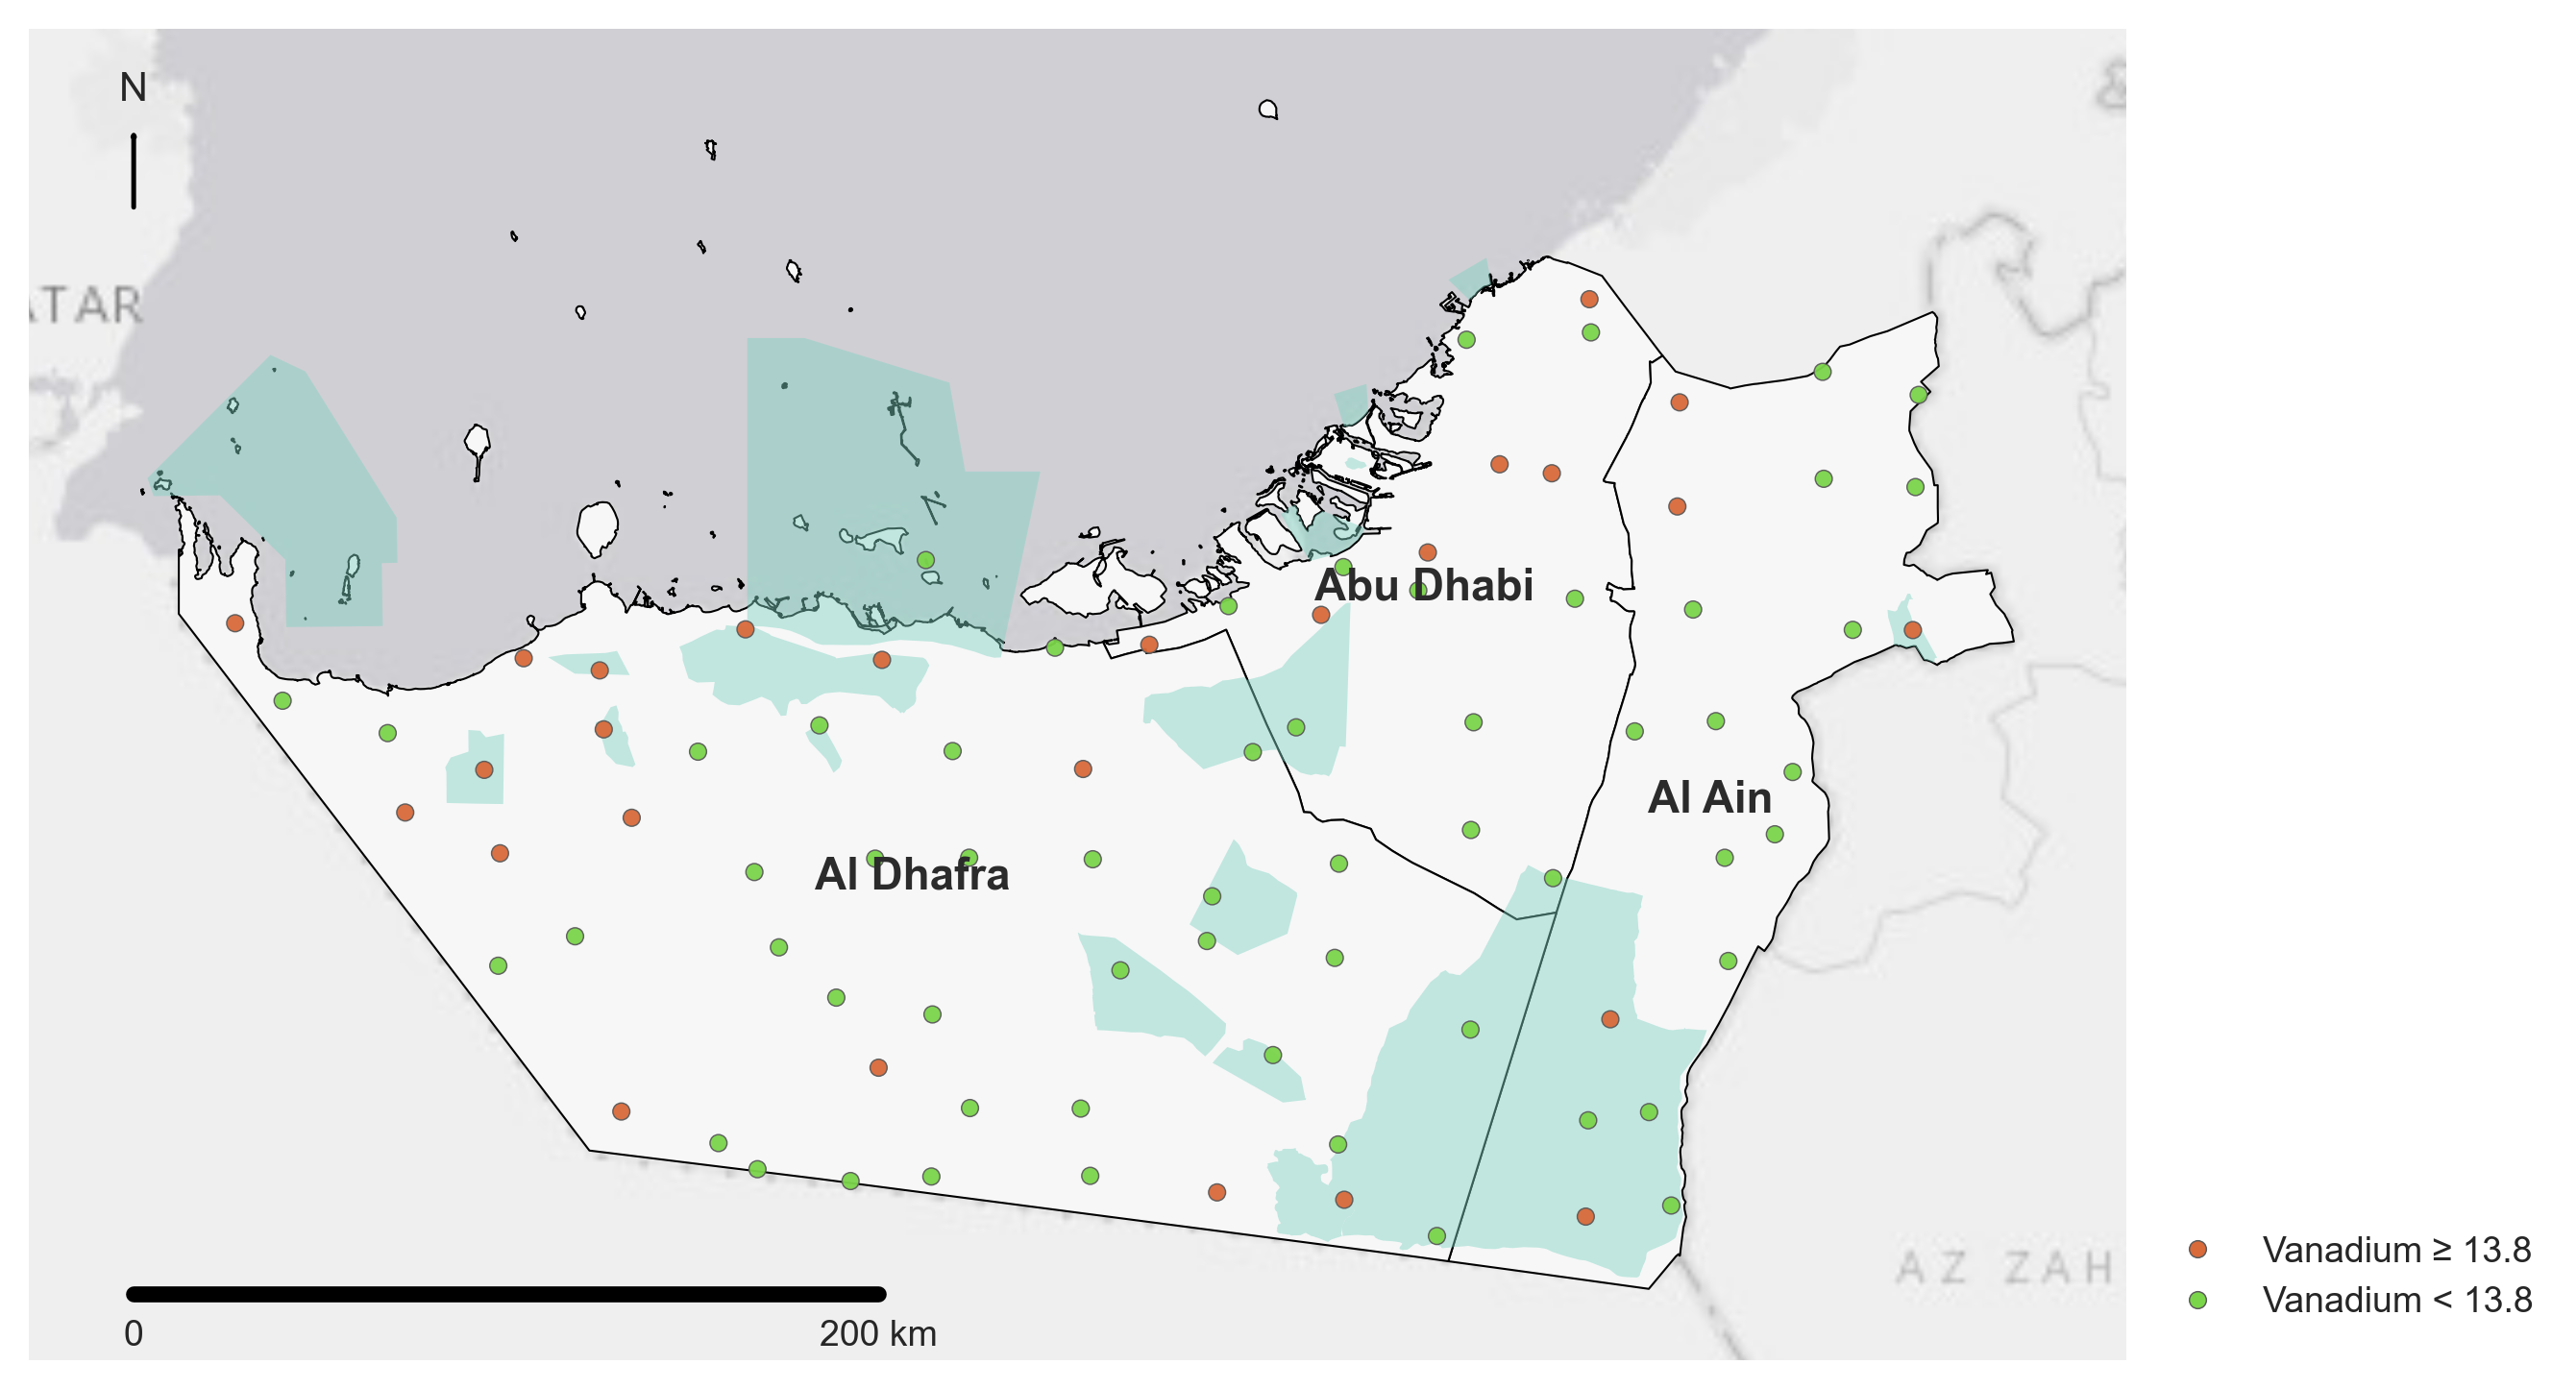

Sites (dedup by SiteUID): 84


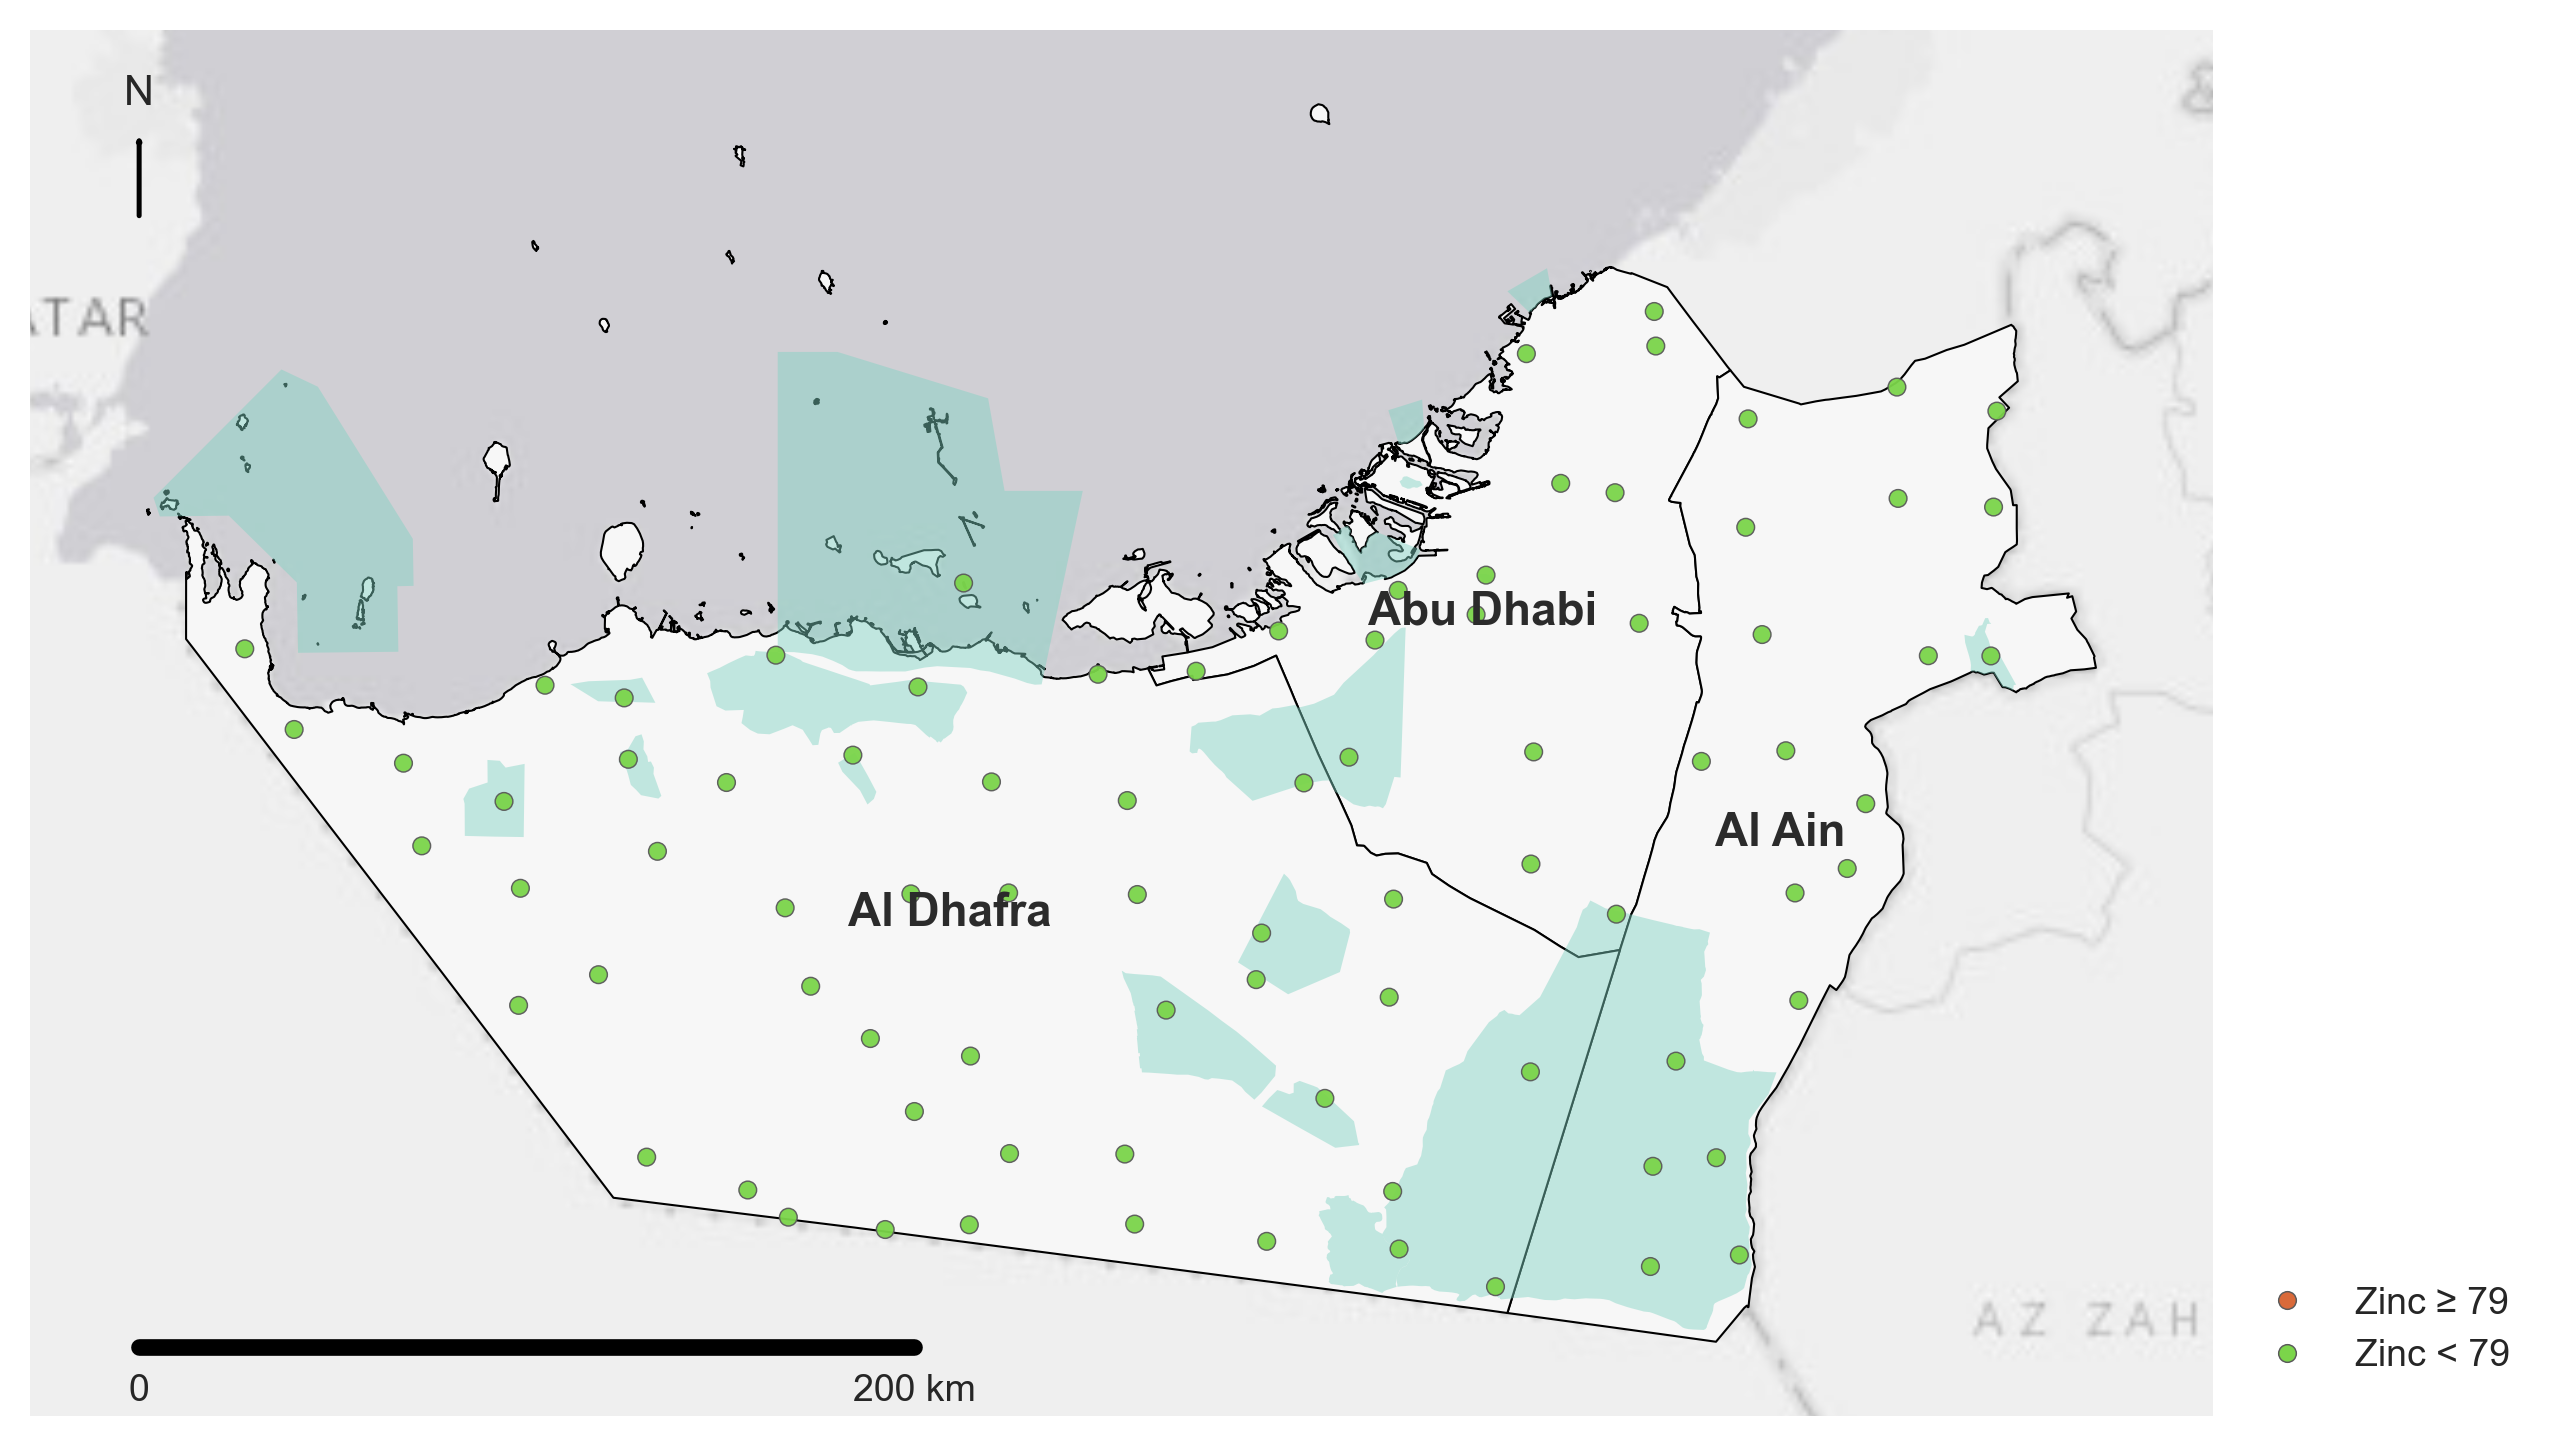

Sites (dedup by SiteUID): 84


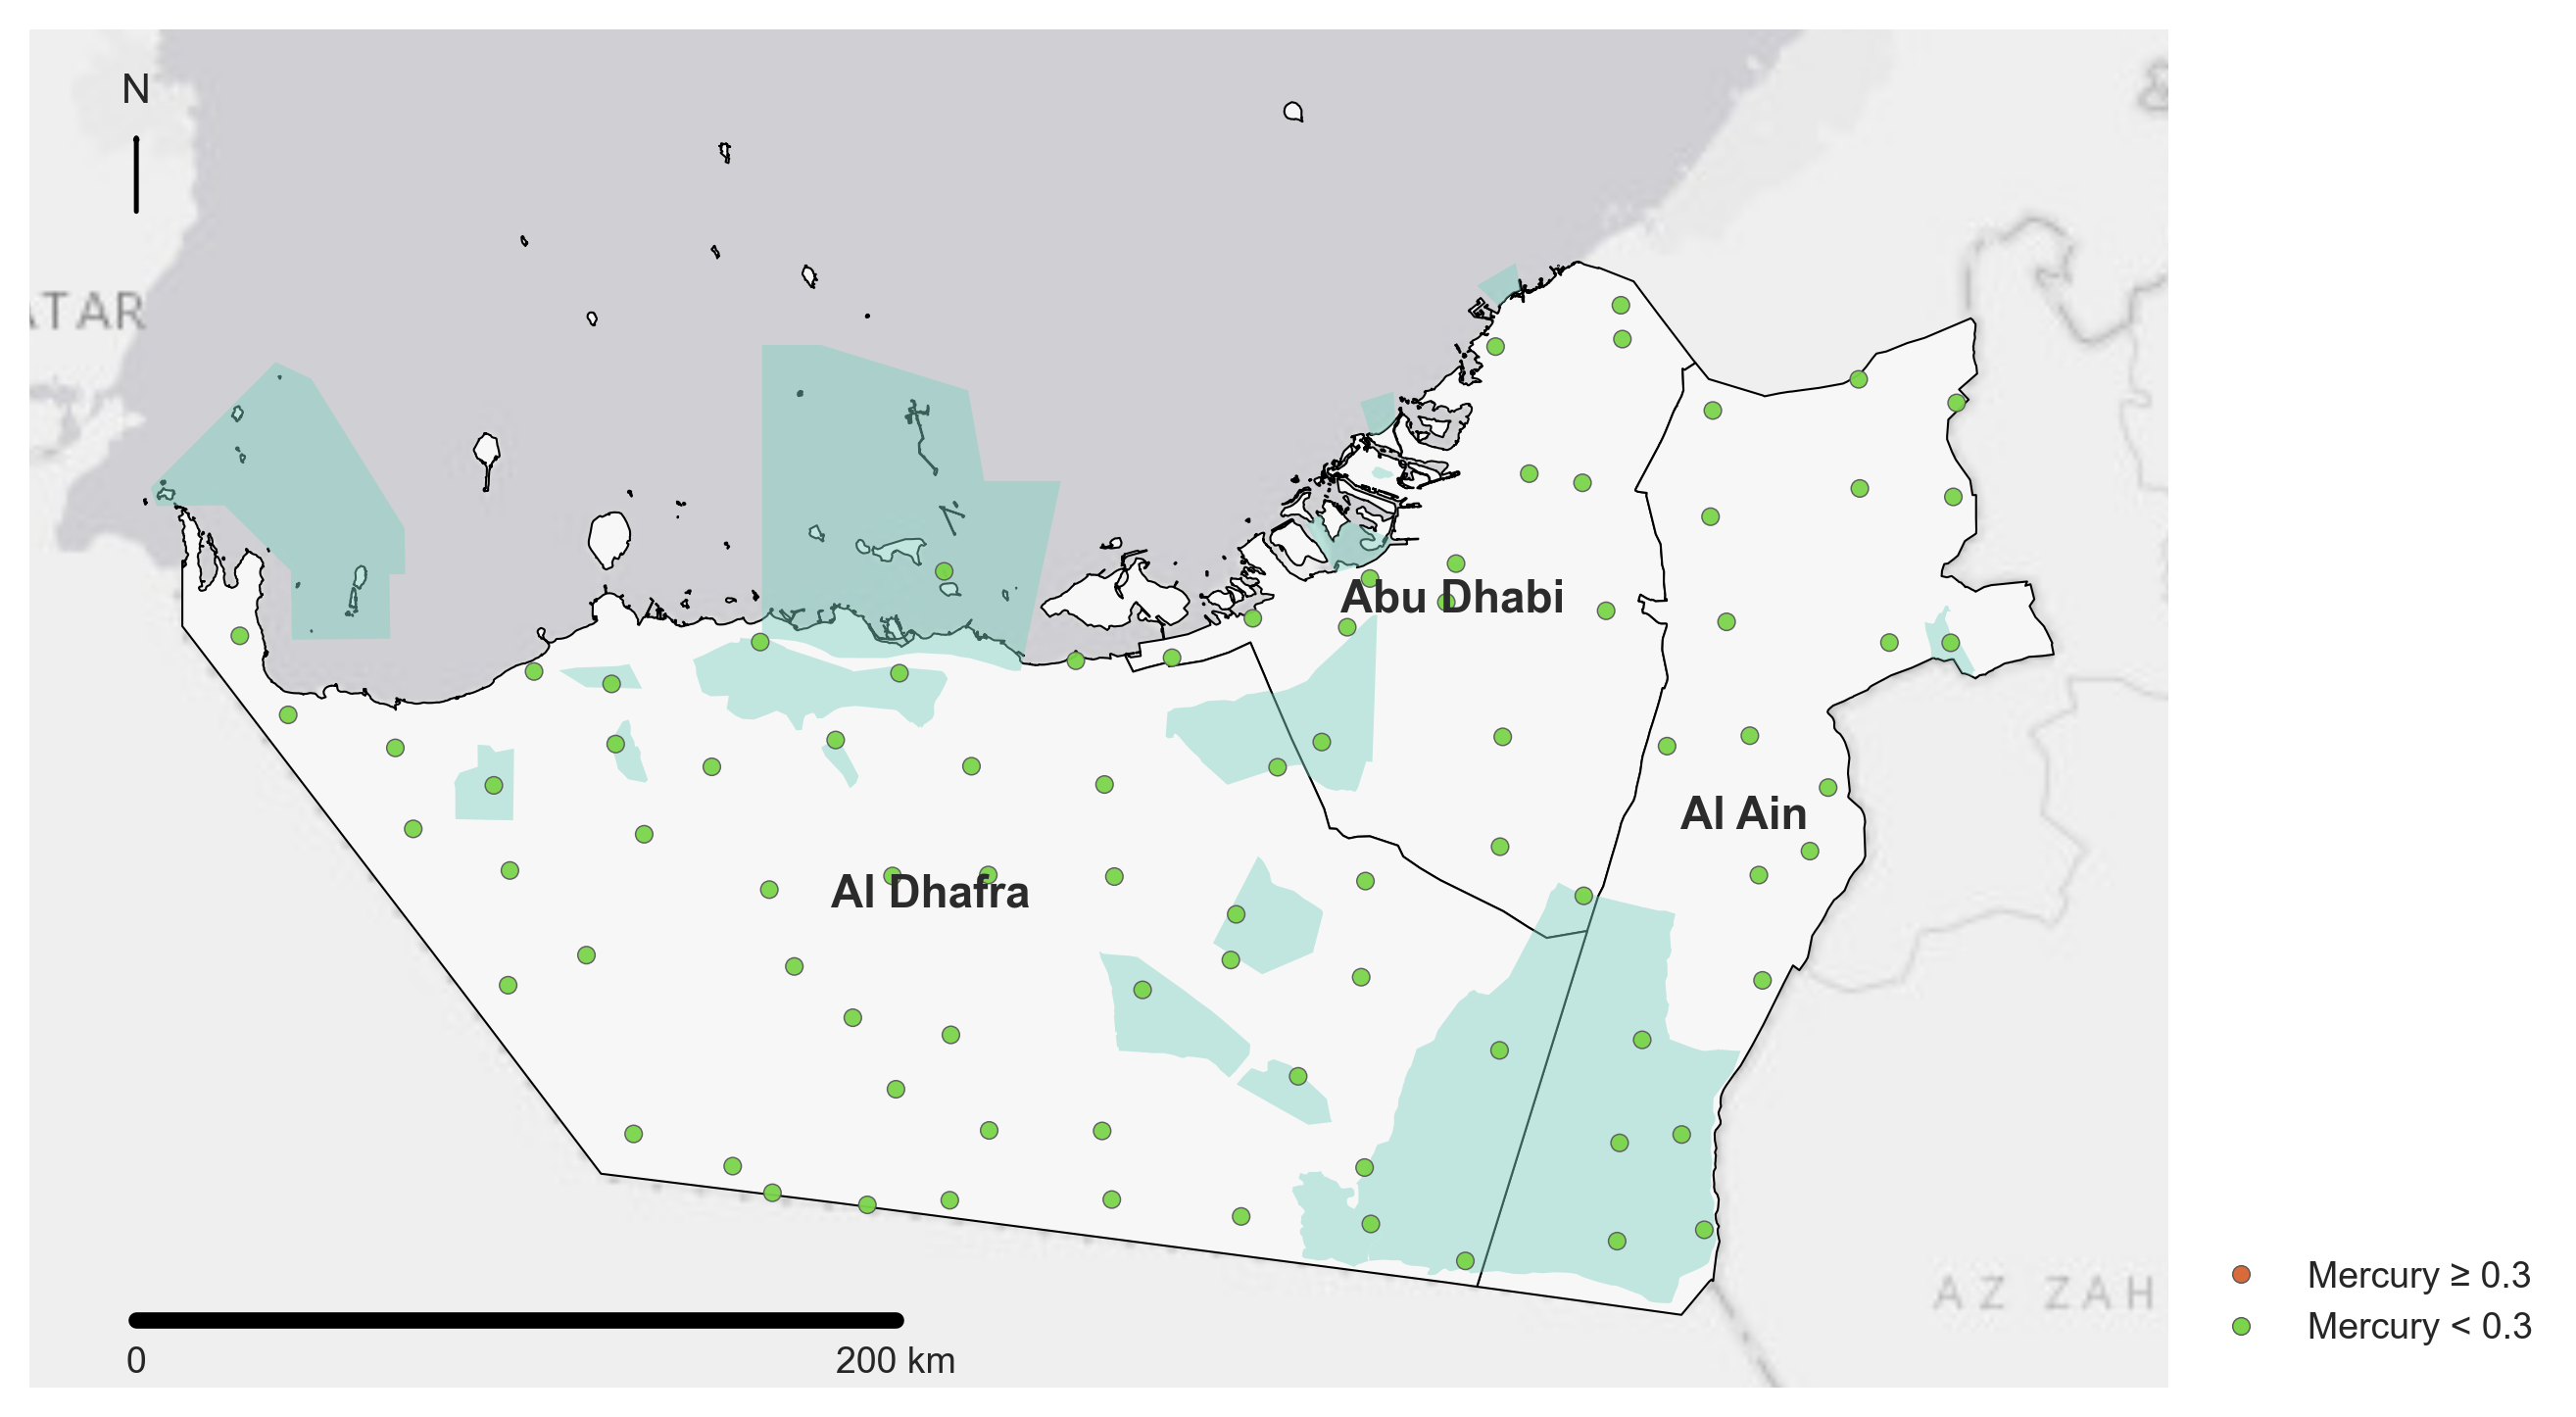

In [6]:
name_dict = {
    "Arsenic": "Arsenic",
    "Beryllium": "Beryllium",
    "Cadmium": "Cadmium",
    "Cobalt": "Cobalt",
    "Copper": "Copper",
    "Chromium (Total)":"Chromium_Total",
    "Lead": "Lead_aqua",
    "Molybdenum": "Molybdenum",
    "Nickel": "Nickel_aqua",
    "Selenium": "Selenium_aqua",
    "Vanadium": "Vanadium",
    "Zinc": "Zinc",
    "Mercury": "InorganicMercury",
}
Threshold_dict = {
    "Arsenic": 18,
    "Beryllium": 10,
    "Cadmium": 0.36,
    "Cobalt": 13,
    "Chromium (Total)": 28.8,
    "Copper": 49,
    "Lead": 56,
    "Molybdenum": 2,
    "Nickel": 57,
    "Selenium": 0.52,
    "Vanadium": 13.8,
    "Zinc": 79,
    "Mercury": 0.3,
}
for name in name_dict.keys():
    screen_level = Threshold_dict[name]

    fig, ax, gdf_pts, regions_gdf, aoi = plot_ph_ssl_full_map(
        excel_path=EXCEL_PATH,
        sheet_name=SHEET_NAME,
        abu_dhabi_shp=ABU_DHABI_SHP,
        protected_gpkg=PROTECTED_GPKG,
        protected_layer=PROTECTED_LAYER,
        element_name=name,
        element_col=name_dict[name],
        # filters
        phuid=1,
        phsampleuid=1,
        survey_id=11,  # e.g. 9 for Industrial
        # SSL threshold
        ph_ssl=screen_level,
        # basemap
        basemap=cx.providers.Esri.WorldGrayCanvas,
        basemap_zoom=7,
        # toggles
        draw_protected=True,
    )
    fig.savefig(os.path.join(OUT_DIR, f"Ch10_{name}_above_below_SSL.png"), bbox_inches="tight", pad_inches=0.1)
    fig.savefig(os.path.join(OUT_DIR, f"Ch10_{name}_above_below_SSL.svg"), bbox_inches="tight", pad_inches=0.1)
